In [2]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from scipy import signal
from IPython.display import Audio
from sklearn.decomposition import NMF
import wavio
import librosa
import pywt
import pycwt
import cvxpy as cp

# Funciones auxiliares

In [3]:
def wiener_filter(V, WiHi, W, H, alpha=1):
    # El filtro de Wiener permite generar una máscara que obtenga información
    # del espectrograma original a partir de la proporción obtenida mediante la
    # multiplicación de las matrices W y H (estimación de la señal original)
    
    # Obteniendo la máscara
    mask = np.divide(WiHi ** alpha, np.matmul(W, H) + 1e-15)
    
    # Aplicando la máscara al espectrograma original, se obtiene el resultado
    # final del proceso de separación de fuentes
    return mask * V

In [4]:
def put_clicks_on_audio(signal_in, samplerate, points_to_put,
                        f_sound=2000, n_sound=1000, k_audio=5, 
                        k_click=2, click_window=None, 
                        normalize=True):
    ''' Función que permite poner clicks de sonido sobre un audio
    
    Parámetros
    - signal_in: Señal de entrada
    - samplerate: Tasa de muestreo de la señal
    - points_to_put: Lista de puntos para poner clicks sobre la señal de 
                     entrada
    - f_sound: Frecuencia a la que sonará el click
    - n_sound: Cantidad de puntos que tendrá el click
    - k_audio: Parámetro de ponderación relativo para la señal de entrada
               Tiene relación con el volumen del audio sobre la salida
    - k_click: Parámetro de ponderación relativo para la señal de click
               Tiene relación con el volumen del click sobre la salida
    - click_windowed: Parámetro que indica si el click es ventaneado
        - [None]: No se ventanea
        - ['hamming']: Se ventanea por una ventana hamming
    - normalize: Booleano para normalización de la señal
    
    Referencias:
    - Elaboración propia
    '''
    # Definición del click
    n = np.arange(n_sound)
    audio_click = np.sin(2 * np.pi * f_sound / samplerate * n)
    
    # Aplicación de ventana
    if click_window == 'hamming':
        audio_click *= np.hamming(len(audio_click))
    elif click_window == 'hann':
        audio_click *= np.hanning(len(audio_click))
    elif click_window == 'blackman':
        audio_click *= np.blackman(len(audio_click))
    elif click_window == 'bartlett':
        audio_click *= np.bartlett(len(audio_click))
    
    # Regulación del volumen de los audios para el sonido final
    audio_mast = signal_in * k_audio
    click_mast = audio_click * k_click

    # Sumando el click en las posiciones donde ocurre el fin/comienzo de un
    # ciclo respiratorio
    audio_out = np.array([i for i in audio_mast])
    
    # Definición del parámetro de largo de la mitad del click
    half_click = len(click_mast) // 2

    # Agregando el click a cada elemento
    for point in points_to_put:
        audio_out[point - half_click:point + half_click] += click_mast
            
    if normalize:
        return audio_out / max(audio_out)
    else:
        return audio_out

In [5]:
def hamming_window(N):
    # Definición de la ventana hamming de modo que se pueda generar para un
    # largo de ventana definido
    return np.asarray([0.53836 - 0.46164*np.cos((2*np.pi*i)/N)
                       for i in range(int(N))])

In [6]:
def recognize_peaks_by_derivates(x, signal_in, peak_type='min', tol_dx=0.01,
    tol_d2x=1e-2, lookup=1500, plot=False):
    # Se definen las derivadas 
    dx = np.gradient(signal_in, x)
    d2x = np.gradient(dx, x)
    
    # Buscando los puntos donde la derivada se vuelve cero
    der_vect_0 = [i for i in range(len(dx)) if abs(dx[i]) <= tol_dx]
    
    # Y definiendo si estos puntos corresponden a mínimos o máximos se realiza
    if peak_type == 'min':
        sel_indexes = [i for i in der_vect_0 if d2x[i] >= tol_d2x]
    elif peak_type == 'max':
        sel_indexes = [i for i in der_vect_0 if d2x[i] <= - tol_d2x]
    elif peak_type == 'all':
        sel_indexes = der_vect_0
    else:
        raise ValueError('La opcion de eleccion de peak utilizada no es valida.')
    
    # Seleccionando un punto característico de la región (ya que
    # muchos de los "puntos" aparecen agrupados en más puntos). En primer lugar,
    # se obtiene un vector de diferencias para conocer los puntos en los que se
    # pasa de un cluster a otro
    dif_indexes = [i + 1 for i in range(len(sel_indexes) - 1)
                   if sel_indexes[i + 1] - sel_indexes[i] > 1] + \
                  [len(sel_indexes) + 1]

    # Separando los clusters de puntos y encontrando el índice representativo de
    # cada uno
    begin = 0
    out_indexes = []
    for i in dif_indexes:
        # Definición del punto posible. Se hace round en caso de que sea un
        # decimal, e int para pasarlo si o si a un elemento tipo "int" para
        # indexar 
        possible_point = int(round(np.mean(sel_indexes[begin:i])))
        
        # Finalmente, se debe reconocer si este punto es realmente un mínimo o
        # un  máximo y no un punto de inflexión. Para ello se revisará en un
        # rango de 'lookup' alrededor de este punto. Definiendo los puntos a
        # revisar 
        look_before = signal_in[possible_point - lookup] \
            if possible_point - lookup >= 0 else signal_in[0]
        look_after  = signal_in[possible_point + lookup] \
            if possible_point + lookup <= len(signal_in) else signal_in[len(signal_in)-1]

        # Luego, realizando la comparación
        if peak_type == 'min':
            # Corroborando que alrededor de este punto se forma un "valle"
            if (look_after > signal_in[possible_point] and 
                look_before > signal_in[possible_point]):
                out_indexes.append(possible_point)

        elif peak_type == 'max':
            # Corroborando que alrededor de este punto se forma una "cueva"
            if (look_after < signal_in[possible_point] and 
                look_before < signal_in[possible_point]):
                out_indexes.append(possible_point)
        
        elif peak_type == 'all':
            # Corroborando alguno de los 2 casos anteriores
            if (look_after > signal_in[possible_point] and 
                look_before > signal_in[possible_point]) or \
               (look_after < signal_in[possible_point] and 
                look_before < signal_in[possible_point]):
                out_indexes.append(possible_point)

        # Redefiniendo el comienzo del análisis
        begin = i
    
    # Graficando para corroborar visualmente
    if plot:
        plt.subplot(3,1,1)
        plt.plot(signal_in)
        plt.plot(out_indexes, [signal_in[i] for i in out_indexes], 'rx')

        plt.subplot(3,1,2)
        plt.plot(dx)

        plt.subplot(3,1,3)
        plt.plot(d2x)

        plt.show()

    return out_indexes

In [7]:
def get_spectrogram(audio, samplerate, N=512, padding=512, overlap=0, window='tukey', whole=False):
    # Lista donde se almacenará los valores del espectrograma
    spect = []
    # Lista de tiempo
    times = []
    
    # Variables auxiliares
    t = 0   # Tiempo
    
    # Seleccionar ventana
    if window == 'tukey':
        wind_mask = tukey(N)
    elif window == 'hamming':
        wind_mask = hamming_window(N)
    elif window == 'hann':
        wind_mask = hann_window(N)
    elif window == 'nuttall':
        wind_mask = nuttall(N)
    elif window is None:
        wind_mask = np.array([1] * N)
    
    # Iteración sobre el audio
    while audio.any():
        # Se corta la cantidad de muestras que se necesite, o bien, las que se
        # puedan cortar
        if len(audio) >= N:
            q_samples = N
            step = int(N * (1 - overlap))
        else:
            break
            # q_samples = step = len(audio)
            
        # Recorte en la cantidad de muestras
        audio_frame = audio[:q_samples]
        audio = audio[step:]
               
        # Ventaneando
        audio_frame_wind = audio_frame * wind_mask
        
        # Aplicando padding
        audio_padded = np.append(audio_frame_wind, [0] * padding)
        
        # Aplicando transformada de fourier
        audio_fft = np.fft.fft(audio_padded)
               
        # Agregando a los vectores del espectro
        spect.append(audio_fft)
        
        # Agregando al vector de tiempo
        times.append(t)
        t += step/samplerate
    
    # Preguntar si se quiere el espectro completo, o solo la mitad (debido a que está reflejado
    # hermitianamente)
    if whole:
        # Generar el vector de frecuencias para cada ventana
        freqs = np.linspace(0, samplerate, N+padding)

        # Una vez obtenido el spect_mag y spect_pha, se pasa a matriz
        spect = np.array(spect, dtype=np.complex64)
    else:
        # Generar el vector de frecuencias para cada ventana
        freqs = np.linspace(0, samplerate//2, (N+padding)//2 + 1)

        # Una vez obtenido el spect_mag y spect_pha, se pasa a matriz
        spect = np.array(spect, dtype=np.complex64)[:, :(N+padding)//2 + 1]
    
    # Se retornan los valores que permiten construir el espectrograma correspondiente
    return times, freqs, spect.T


def get_inverse_spectrogram(X, overlap=0, window='tukey', whole=False):
    # Preguntar si es que la señal está en el rango 0-samplerate. En caso de 
    # que no sea así, se debe concatenar el conjugado de la señal para 
    # recuperar el espectro. Esto se hace así debido a la propiedad de las 
    # señales reales que dice que la FT de una señal real entrega una señal 
    # hermitiana (parte real par, parte imaginaria impar). Luego, como solo 
    # tenemos la mitad de la señal, la otra parte correspondiente a la señal 
    # debiera ser la misma pero conjugada, para que al transformar esta señal 
    # hermitiana mediante la IFT, se recupere una señal real (correspondiente a 
    # la señal de audio).
    if not whole:
        # Se refleja lo existente utilizando el conjugado
        X = np.concatenate((X, np.flip(np.conj(X[1:-1, :]), axis=0)))
        
    # Obtener la dimensión de la matriz
    rows, cols = X.shape
    
    # Seleccionar ventana
    if window == 'tukey':
        wind_mask = tukey(rows)
    elif window == 'hamming':
        wind_mask = hamming_window(rows)
    elif window == 'hann':
        wind_mask = hann_window(rows)
    elif window == 'nuttall':
        wind_mask = nuttall(rows)
    elif window is None:
        wind_mask = np.array([1] * rows)
        
    # A partir del overlap, el tamaño de cada ventana de la fft (dimensión fila)
    # y la cantidad de frames a las que se les aplicó la transformación 
    # (dimensión columna), se define la cantidad de muestras que representa la
    # señal original
    step = int(rows * (1 - overlap))      # Tamaño del paso
    total_samples = step * cols + rows    # Tamaño total del arreglo
    
    # Definición de una lista en la que se almacena la transformada inversa
    inv_spect = np.zeros((total_samples,), dtype=np.complex128)
    # Definición de una lista de suma de ventanas cuadráticas en el tiempo
    sum_wind2 = np.zeros((total_samples,), dtype=np.complex128)
    
    # Transformando columna a columna (nótese la división en tiempo por una 
    # ventana definida)
    for i in range(cols):
        beg = i * step
        # Se multiplica por el kernel para la reconstrucción a partir de la
        # ventana aplicada inicialmente. Fuente:
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.istft.html
        inv_spect[beg:beg+rows] += np.fft.ifft(X[:, i]) * wind_mask
        
        # Se suma la ventana al cuadrado (que sirve como ponderador)
        sum_wind2[beg:beg+rows] += wind_mask ** 2
    
    # Finalmente se aplica la normalización por la cantidad de veces que se
    # suma cada muestra en el proceso anterior producto del traslape,
    # utilizando las ventanas correspondientes
    return np.divide(inv_spect, sum_wind2 + 1e-15)

In [8]:
def beta_kaiser(A):
    '''Función por tramos que indica el valor que debe tomar el
    parámetro beta
    
    Parámetros
    - A: Ganancia máxima entre ripple de pasa banda y rechaza 
         banda obtenido anteriormente mediante la parametrización
         
    Referencias
    [1] Digital Signal Processing: Principles, Algorithms, and 
        Applications by J. G. Proakis and D. G. Manolakis.
    '''
    if A < 21:
        return 0
    elif 21 <= A <= 50:
        return 0.5842 * (A - 21) ** 0.4 + 0.07886 * (A - 21)
    else:
        return 0.1102 * (A - 8.7)

In [9]:
def SNR(signal_in, signal_denoised, snr_type='db'):
    if snr_type == 'db':
        return 10 * np.log10(sum(signal_in ** 2) / 
                             sum((signal_in - signal_denoised) ** 2)) 

    
def decimation_signal(signal_in, N_decimate):
    return signal_in[::N_decimate]


def stretch_signal(signal_in, N_stretch):
    return np.array([signal_in[i//N_stretch] if i%N_stretch == 0 else 0
                     for i in range(len(signal_in) * N_stretch)])


def moving_average(signal_in, Lf):
    # Definición de N
    N = len(signal_in)
    # Creación del vector del resultado
    result = np.zeros(N)
    
    # Se hace el promedio para cada segmento
    for n in range(N):
        if 0 <= n <= Lf - 1:
            result[n] = np.divide(sum(signal_in[:n+Lf+1]), Lf + n + 1)
        elif Lf <= n <= N - Lf - 1:
            result[n] = np.divide(sum(signal_in[n-Lf:n+Lf+1]), 2*Lf + 1)
        elif N - Lf <= n <= N - 1:
            result[n] = np.divide(sum(signal_in[n-Lf:N]), Lf + N - 1)
            
    return result


def find_valley_point(signal_in):
    # En primer lugar, encontrar el primer punto máximo de la señal (peak)
    primary_peak = np.argmax(signal_in)
    # print(primary_peak)

    
def zeropadding_to_pot2(signal_in):
    '''Se busca saber entre qué potencias de 2 se encuentra se encuentra el largo del arreglo,
    el cual está dado por aplicar el logaritmo base 2 al largo de la señal. Con esto, se 
    obtiene la cantidad de 'potencias de 2' que hay que aplicar al largo para obtenerlo.
    Se toma este número, y se obtiene la parte entera de él.
    
    Esta función busca rellenar con ceros hasta que el largo de la señal sea una potencia de 2.
    
    Parámetros
    - signal_in: Señal a rellenar con ceros'''
    # Pasar la señal a arreglo de numpy
    signal_in = np.array(signal_in)
    
    # Potencia de 2 por lo bajo del largo de la señal
    n2_pot = int(np.log2(len(signal_in)))
    
    # Luego, la cantidad de ceros que hay que agregar a la señal para 
    # que sea tenga como largo una potencia de 2 corresponde a 
    # 2 ** (n2_pot+1) - largo_de_señal
    n = n2_pot + 1
    
    return np.append(signal_in, [0] * (2**n - len(signal_in)))
    

def find_potential_onset_offset(signal_in, det_type):
    '''Función que permite encontrar los potenciales onsets basado en la
    revisión de puntos adyacentes. Se revisa si es que el punto actual es 
    cero y el punto siguiente es distinto de cero. Si se cumple, es porque
    se está en presencia de un "onset".
    Referencias: 
    - Qingshu Liu, et.al. An automatic segmentation method for heart sounds.
      2018. Biomedical Engineering.
    
    Parámetros
    - signal_in: Señal de entrada
    - det_type: Opción para el tipo de salida
        - [onset]: Retorna los onset (inicio de sonidos cardíacos)
        - [offset]: Retorna los offset (fin de sonidos cardíacos)
        - [all]: Retorna tanto onsets como offsets
    '''
    if det_type == 'onset':
        return [i for i in range(len(signal_in)-1) 
                if signal_in[i] == 0 and signal_in[i+1] != 0]
    elif det_type == 'offset':
        return [i for i in range(1, len(signal_in)) 
                if signal_in[i-1] != 0 and signal_in[i] == 0]
    elif det_type == 'all':
        all_points = [i for i in range(len(signal_in)-1) 
                      if signal_in[i] == 0 and signal_in[i+1] != 0] + \
                     [i for i in range(1, len(signal_in)) 
                      if signal_in[i-1] != 0 and signal_in[i] == 0]
        # Ordenando
        all_points.sort()
        return all_points
    
    else:
        raise Exception('Opción seleccionada no es válida. Ingrese un tipo '
                        'de salida disponible en las opciones.')
        
        
def get_zero_points(signal_in, complement=False, tol=1e-12, 
                    to_return='all'):
    '''Función que permite encontrar los ceros de la señal
    
    Parámetros
    - signal_in: Señal de entrada
    - complement: Booleano que indica si se entregan los puntos de 
                  la señal donde se encuentran los ceros. Si es "True"
                  se entregan todos los puntos distintos de cero. Si es
                  "False", se entregan todos los puntos en cero. Por
                  defecto se deja en "False"
    - tol: Rango de tolerancia para los valores "cero"
    - to_return: Lista de puntos que se entregará
        - ['all']: Se retornan directamente todos los puntos encontrados
        - ['center']: Se retornan los puntos centrales de cada uno de los
                      clusters obtenidos
    '''
    # Selección de tipo de puntos con respecto a los ceros
    if complement:
        point_list = [i for i in range(len(signal_in)) 
                      if abs(signal_in[i]) >= tol]
    else:
        point_list = [i for i in range(len(signal_in)) 
                      if abs(signal_in[i]) <= tol]
        
    if to_return == 'all':
        return point_list
    elif to_return == 'center':
        # Seleccionando un punto característico de la región (ya que muchos
        # de los "puntos" aparecen agrupados en más puntos). En primer lugar,
        # se obtiene un vector de diferencias para conocer los puntos en los
        # que se pasa de un cluster a otro
        dif_indexes = [i + 1 for i in range(len(point_list) - 1)
                       if point_list[i + 1] - point_list[i] > 1] + \
                      [len(point_list) + 1]
        
        # Separando los clusters de puntos y encontrando el índice representativo de
        # cada uno
        begin = 0
        out_indexes = []
        for i in dif_indexes:
            # Definición del punto posible. Se hace round en caso de que sea un
            # decimal, e int para pasarlo si o si a un elemento tipo "int" para
            # indexar 
            out_indexes.append(int(round(np.mean(point_list[begin:i]))))
            # Redefiniendo el comienzo del análisis
            begin = i
        
        return out_indexes

# Thresholding functions

In [10]:
def Sure_Shrink(signal_in, solve_method='iterations', step=0.001):
    ''' Aplicación del problema de optimización mediante SURE para
    la definición de un valor umbral que permita hacer denoising de
    la señal descompuesta en wavelets.
    
    Parámetros
    - signal_in: Señal de entrada x_i
    - solve_method: Método de resolución del valor "t"
        - ["iterations"]: Se resuelve viendo todos los posibles valores
                          entre cero y el máximo de la señal
        - ["optimization"]: Se resuelve mediante el problema de optimización.
                            TODAVIA NO FUNCIONA
    - step: Valor del salto aplicado al vector que se crea en el
            método de resolución 'iterations'. Se crea un vector
            que avanza en este monto hasta el máximo del valor
            absoluto de la señal
    
    Referencias:
    (1) Cai, C., & Harrington, P. de B. (1998). Different Discrete 
        Wavelet Transforms Applied to Denoising Analytical Data
    (2) G.P. Nason (2008). Wavelet Methods in Statistics with R.
    (3) Donoho, D. L., & Johnstone, I. M. (1995). Adapting to 
        Unknown Smoothness via Wavelet Shrinkage. Journal of the 
        American Statistical Association
    '''
    # Definición de N
    N = len(signal_in)
    
    # Función auxiliar que cuenta la cantidad de puntos en que la magnitud
    # de la señal es menor a un parámetro t
    count = lambda t: sum(abs(signal_in) <= t)
    
    # Función auxiliar que compara la magnitud de la señal con un parámetro 
    # t, escoge el mínimo y lo eleva al cuadrado generando un arreglo de 
    # valores de este tipo. Luego se suma cada uno
    #min_comp = lambda t: sum([min(abs(x_i), t) ** 2 for x_i in signal_in])
    min_comp = lambda t: sum(np.where(abs(signal_in) < t, 
                                      abs(signal_in) ** 2, 
                                      t ** 2))
    
    # Definición de la función/expresión SURE (función objetivo)
    sure_fo = lambda t: N - 2 * count(t) + min_comp(t)
    
    if solve_method == 'optimization': #### POR COMPLETAR
        # Definición de la variable a optimizar -> delta es el t óptimo
        delta = cp.Variable()

        # Definición de las restricciones
        constraints = [delta >= 0,
                       delta <= np.sqrt(2 * np.log(N))]

        # Definición de la función objetivo
        obj = cp.Minimize(sure_fo(delta))

        # Definición del problema de optimización
        prob = cp.Problem(obj, constraints)

        # Resolviendo el problema
        prob.solve(solver=cp.GUROBI, verbose=True)
    
    elif solve_method == 'iterations':
        # Definición de los posibles valores de t
        possible_t = np.arange(0, max(abs(signal_in)), step=step)
        
        # Definición de los valores de SURE a revisar
        sure_to_review = list()
        
        for i in possible_t:
            sure_to_review.append(abs(sure_fo(i)))
        
        # Una vez calculadas todas las SURE, se busca el índice 
        # del mínimo
        index_optimum = sure_to_review.index(min(sure_to_review))
        
        # Finalmente, se obtiene el valor del delta
        delta = possible_t[index_optimum]
    
        return delta
      

def wavelet_thresholding(signal_in, delta=None, threshold_criteria='soft',
                         threshold_delta='mad', min_percentage=None,
                         print_delta=False):
    '''Definición de los tipos de thresholding aplicados a una función transformada
    al dominio wavelet.
    
    Parámetros
    - signal_in: Señal de entrada
    - delta: Valor del umbral manual. En caso de no querer ingresar este valor
             por defecto se mantiene como "None"
    - threshold_criteria: Criterio de aplicación de umbral, entre "hard" y "soft"
    - threshold_delta: Selección del criterio de cálculo de umbral. Opciones:
        - ["mad"]: Median Absolute Deviation
        - ["universal"]: universal (4)
        - ["sureshrink"]: Aplicando SURE (4)
        - ["percentage"]: Aplicación del porcentage en relación al máximo
    - min_percentage: Valor del porcentaje con respecto al máximo en la opción
                      "percentage" de la variable "threshold_delta"
    - print_delta: Booleano para indicar si se imprime el valor de delta
                      
    Referencias: 
    (1) http://www.numerical-tours.com/matlab/denoisingwav_1_wavelet_1d/
    (2) https://dsp.stackexchange.com/questions/15464/wavelet-thresholding
    (3) Valencia, D., Orejuela, D., Salazar, J., & Valencia, J. (2016). 
        Comparison analysis between rigrsure, sqtwolog, heursure and 
        minimaxi techniques using hard and soft thresholding methods.
    (4) Cai, C., & Harrington, P. de B. (1998). Different Discrete Wavelet
        Transforms Applied to Denoising Analytical Data
    '''
    # Definición del umbral de corte
    if delta is None:
        if threshold_delta == 'mad':
            # Se calcula la mediana
            med = np.median(signal_in)
            # Y se obtiene el sigma usando la median absolute deviation (MAD)
            sigma = np.median(abs(signal_in - med)) / 0.6745
            # Luego delta está dado por
            delta = sigma * np.sqrt(2 * np.log(len(signal_in)))
        
        elif threshold_delta == 'universal':
            # Se calcula la mediana de la magnitud
            med = np.median(abs(signal_in))
            # Estimación del sigma
            sigma = med / 0.6745
            # Luego el delta está dado por
            delta = sigma * np.sqrt(2 * np.log(len(signal_in)))
        
        elif threshold_delta == 'sureshrink':
            delta = Sure_Shrink(signal_in, solve_method='iterations', 
                                step=0.001)
        
        elif threshold_delta == 'percentage':
            delta = min_percentage * max(abs(signal_in))
            
    if print_delta:
        print(delta)

    # Opciones de corte para el umbral
    if threshold_criteria == 'hard':
        return np.array([i if abs(i) > delta else 0 for i in signal_in])
    
    elif threshold_criteria == 'soft':
        # Definición de la operación soft
        soft_operator = lambda x: max(0, 1 - delta/abs(x + 1e-15)) * x
        return np.array([soft_operator(i) for i in signal_in])
    
    
def thresholding_processing(signal_in):
    '''Proceso que permite separar las envolventes de los murmullos del primer
    sonido cardíaco (S1) que no fueron totalmente removidos por ALPF
    
    Referencias: 
    - Qingshu Liu, et.al. An automatic segmentation method for heart sounds.
      2018. Biomedical Engineering.
    '''
    
    # Definición de los parámetros según el paper
    lamb = 0.8
    theta_c = 0.025
    
    # Definición del factor dependiente de la naturaleza de la señal
    theta_a = lamb * np.std(signal_in)
    
    # Definición del umbral de corte
    theta = min(theta_a, theta_c)
    
    return np.array([i if abs(i) >= theta else 0 for i in signal_in])

# Wavelets

In [11]:
def dwt_decomposition(signal_in, wavelet='db4', mode='periodization',
                      levels='all', return_concatenated=False):
    '''Esta función permite descomponer una señal de entrada en todos los
    posibles niveles de wavelet producto de la aplicación de la "Discrete
    Wavelet Transform" (DWT).
    
    Parámetros
    - signal_in: Señal de entrada
    - wavelet: Wavelet utilizado para el proceso de dwt. Revisar en 
               pywt.families(kind='discrete')
    - mode: Tipo de descomposición en wavelets (revisar wavelets del 
                paquete pywt)
    - levels: Niveles de descomposición para la aplicación de la
                transformada en wavelets.
        - ['all']: Realiza el proceso de disminución a la mitad hasta
                   llegar al final del proceso
        - [(int)#]: Es posible entregar la cantidad de niveles a 
                    descomponer
    - return_concatenated: Booleano que pregunta si es que la salida se
                    entregará concatenada. Al aplicar 'True', se entregará
                    un arreglo con todas las etapas concatenadas. En caso
                    contrario, se entregará una lista donde cada uno de los
                    N + 1 elementos estarán dado por los N coeficientes de
                    detalle, y el último será el/los último/s coeficiente/s 
                    de aproximación
    '''
    # Definición de la señal a descomponer
    to_decompose = signal_in
    
    # Rutina para salida concatenada
    if return_concatenated:
        # Definición del vector wavelet de salida
        wavelet_out = np.array([])
        
        # Para descomposición en todos los niveles posibles
        if levels == 'all':
            while len(to_decompose) > 1:
                # Descomposición de wavelet
                (to_decompose, cD) = pywt.dwt(to_decompose, wavelet=wavelet, 
                                              mode=mode)
                
                # Agregando el detalle al final del vector de salida
                wavelet_out = np.append(cD, wavelet_out)
        
        # Para selección de niveles
        elif isinstance(levels, int):
            # Descomponiendo en niveles
            for _ in range(levels):
                # Descomposición de wavelet
                (to_decompose, cD) = pywt.dwt(to_decompose, wavelet=wavelet, 
                                              mode=mode)

                # Agregando el detalle al final del vector de salida
                wavelet_out = np.append(cD, wavelet_out)

        return np.append(to_decompose, wavelet_out)
        
    # Rutina para salida no concatenada
    else:
        # Definición de la lista de wavelets de salida
        wavelets_out = list()
        
        if levels == 'all':
            while len(to_decompose) > 1:
                # Descomposición de wavelet
                (to_decompose, cD) = pywt.dwt(to_decompose, wavelet=wavelet, 
                                              mode=mode)

                # Agregando el detalle a la lista
                wavelets_out.append(cD)
        
        elif isinstance(levels, int):
            # Descomponiendo en niveles
            for _ in range(levels):
                # Descomposición de wavelet
                (to_decompose, cD) = pywt.dwt(to_decompose, wavelet=wavelet, 
                                              mode=mode)

                # Agregando el detalle al final del vector de salida. Se agregan,
                # considerando que son N niveles de descomposición, de la forma
                # d1, d2, ... , dN 
                wavelets_out.append(cD)

        # Y finalmente se guarda la aproximación
        wavelets_out.append(to_decompose)

        return wavelets_out


def dwt_recomposition(signal_in, wavelet='db4', mode='periodization',
                      levels='all', is_concatenated=False):
    '''Esta función permite recomponer una señal de entrada en todos los
    posibles niveles de wavelet producto de la aplicación de la "Discrete
    Wavelet Transform" (DWT).
    
    Parámetros
    - signal_in: Señal de entrada
    - wavelet: Wavelet utilizado para el proceso de dwt. Revisar en 
               pywt.families(kind='discrete')
    - mode: Tipo de descomposición en wavelets (revisar wavelets del 
                paquete pywt)
    - levels: Niveles de descomposición para la aplicación de la
                transformada en wavelets.
        - ['all']: Realiza el proceso de disminución a la mitad hasta
                   llegar al final del proceso
        - [(int)#]: Es posible entregar la cantidad de niveles a 
                    recomponer
    - is_concatenated: Booleano que pregunta si es que la entrada se
                    entregará concatenada. Al aplicar 'True', se procesará
                    un arreglo con todas las etapas concatenadas. En caso
                    contrario, se entregará una lista donde cada uno de los
                    N + 1 elementos estarán dado por los N coeficientes de
                    detalle, y el último será el/los último/s coeficiente/s 
                    de aproximación
    '''
    # Rutina para entrada concatenada
    if is_concatenated:
        if levels == 'all':
            # Definición de los niveles de reconstrucción
            N = int(np.log2(len(signal_in)))

            # Definición de la señal a recomponer
            cA = np.array([signal_in[0]])

            for i in range(N):
                to_look = 2 ** (i+1)

                # Definición del cD y cA de turno
                cD = signal_in[to_look//2:to_look]
                cA = pywt.idwt(cA, cD, wavelet=wavelet, 
                               mode=mode)

            return cA
    
    else:
        # Definición de los niveles de reconstrucción (el "-1" se debe a
        # que el último elemento es el de aproximación)
        N = len(signal_in) - 1
        
        # Definición de la primera componente de aproximación
        cA = signal_in[-1]
        
        # Iteraciones hasta la recomposición
        for i in reversed(range(N)):
            # Definición del cA de turno (se ajusta el tamaño de
            # cA al tamaño de la señal original ingresada)
            cA = pywt.idwt(cA[:len(signal_in[i])], signal_in[i], 
                           wavelet=wavelet, mode=mode)
            
        return cA

In [12]:
def get_wav_of_dwt_level(filename, level_to_get, levels,
                         wavelet='db4', thresholded=True,
                         delta=None, threshold_criteria='hard',
                         threshold_delta='universal',
                         min_percentage=None, print_delta=True):
    '''Creación de sonidos en formato .wav a partir de wavelets de obtenidas
    recuperando el wavelet de un nivel en particular
    
    Parámetros
    - filename: Nombre del archivo a procesar
    - level_to_get: Wavelet del nivel a recuperar
    - levels: Cantidad de niveles en las que se descompondrá la señal
    - wavelet: Wavelet utilizado para el proceso de dwt. Revisar en 
               pywt.families(kind='discrete')
    - delta: Definición de umbral de corte en caso de aplicar thresholding
    - threshold_criteria: Criterio de aplicación de umbral, entre "hard" y "soft"
    - threshold_delta: Selección del criterio de cálculo de umbral. Opciones:
        - ["mad"]: Median Absolute Deviation
        - ["universal"]: universal (4)
        - ["sureshrink"]: Aplicando SURE (4)
        - ["percentage"]: Aplicación del porcentage en relación al máximo
    - min_percentage: Valor del porcentaje con respecto al máximo en la opción
                      "percentage" de la variable "threshold_delta
    - print_delta: Booleano para indicar si se imprime el valor de delta
    '''
    # Cargando señal a procesar
    signal_in, samplerate = sf.read(f'{filename}.wav')
    
    # Probando DWT
    dwt_values = dwt_decomposition(signal_in, wavelet=wavelet, 
                                   mode='periodization',
                                   levels=levels, 
                                   return_concatenated=False)
    
    # Definición de la señal a recuperar según el orden del nivel
    n = level_to_get - 1
    
    if thresholded:
        signal_out = wavelet_thresholding(dwt_values[n], delta=delta, 
                                          threshold_criteria=threshold_criteria,
                                          threshold_delta=threshold_delta,
                                          min_percentage=min_percentage,
                                          print_delta=print_delta)
    else:
        # Señal a obtener
        signal_out = dwt_values[n]
    
    # Samplerate de la señal a recuperar
    sr_out = samplerate // (2 ** level_to_get)
    
    # Generando el archivo de audio
    wavio.write(f"{filename}_DWT_level_{level_to_get}_SR{sr_out}.wav", 
                signal_out, sr_out, sampwidth=3)

# Operaciones morfológicas

In [13]:
def erosion_dilation_operation(signal_in, Q, op_type='erosion',
                               g_type='zeros',g_def=None):
    '''Definición de la operación de erosión/dilatación basada en 
    transformaciones morfológicas. 
    
    Disponible en: 
    - https://en.wikipedia.org/wiki/Erosion_(morphology)
    - https://en.wikipedia.org/wiki/Dilation_(morphology)
    
    Ref. anexa: https://opencv-python-tutroals.readthedocs.io/en/latest/
    py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html
    
    Parámetros
    - signal_in: Señal a erosionar/dilatar
    - Q: Tamaño del kernel g(n) (si es par, se le suma 1)
    - g_type: Tipo de kernel a usar.
        - [zeros]: Vector cero de largo Q (o Q+1)
        - [user_defined]: Vector de largo Q (o Q+1) a definir por el usuario
        
    ** Nota **: Se usa Q+1 para que el queden ventanas de largo impar con un
    único punto central.
    '''
    # Propiedad de Q (si es par, se le suma 1)
    if Q % 2 == 0:
        Q += 1
        
    # Definición del radio de la ventana (window ratio)
    ratio = Q // 2
    
    # Definición de N
    N = len(signal_in)
    
    # Definición del kernel g(n)
    if g_type == 'user_defined':
        g_n = g_def[:Q+1]
    elif g_type == 'zeros':
        g_n = np.zeros(Q+1)
        
    # Definición de la función a aplicar
    if op_type == 'erosion':
        func = lambda x: min(x)
    elif op_type == 'dilation':
        func = lambda x: max(x)
    
    # Creación del vector de erosión
    signal_out = np.zeros(N)

    # Se hace aplica erosión dependiendo del segmento. Esto se hace ya que las
    # ventanas que están en los bordes de la señal no alcanzan necesariamente a
    # juntar los Q puntos. Por ende, es necesario ajustar los tamaños de las
    # ventanas en los bordes
    for n in range(N):
        if 0 <= n <= Q//2 - 1:
            signal_out[n] = func(signal_in[:n+ratio+1])
        elif Q//2 <= n <= N - Q//2 - 1:
            signal_out[n] = func(signal_in[n-ratio:n+ratio+1])
        elif N - Q//2 <= n <= N - 1:
            signal_out[n] = func(signal_in[n-ratio:])
    
    # Se entrega finalmente el vector erosionado
    return signal_out


def closing_operation(signal_in, Q=30, g_type='zeros',g_def=None,
                      normalized=True):
    '''Operación morfológica que permite obtener la envolvente de la señal.
    Corresponde a dilatar y luego erosionar la señal.
    Referencias: 
    - Qingshu Liu, et.al. An automatic segmentation method for heart sounds.
      2018. Biomedical Engineering.
    - https://homepages.inf.ed.ac.uk/rbf/HIPR2/close.htm'''
    
    # En primer lugar se dilata la señal
    dilated_signal = erosion_dilation_operation(signal_in, Q=Q, 
                                                op_type='dilation',
                                                g_type=g_type, g_def=g_def)
    # Y luego de erosiona
    closed_signal =  erosion_dilation_operation(dilated_signal, Q=Q, 
                                                op_type='erosion',
                                                g_type=g_type, g_def=g_def)
    
    # Normalización
    if normalized:
        return closed_signal / max(abs(closed_signal))
    else:
        return closed_signal

    
def opening_operation(signal_in, Q=50, g_type='zeros',g_def=None,
                      normalized=True):
    '''Operación morfológica que permite obtener la envolvente de la señal.
    Corresponde a dilatar y luego erosionar la señal.
    Referencias: 
    - Qingshu Liu, et.al. An automatic segmentation method for heart sounds.
      2018. Biomedical Engineering.
    - https://homepages.inf.ed.ac.uk/rbf/HIPR2/close.htm'''
    
    # En primer lugar se dilata la señal
    eroded_signal = erosion_dilation_operation(signal_in, Q=Q, 
                                               op_type='erosion',
                                               g_type=g_type, g_def=g_def)
    # Y luego de erosiona
    opened_signal = erosion_dilation_operation(eroded_signal, Q=Q, 
                                               op_type='dilation',
                                               g_type=g_type, g_def=g_def)
    
    # Normalización
    if normalized:
        return opened_signal / max(abs(opened_signal))
    else:
        return opened_signal

# Pasa bajos

In [14]:
def lowpass_cut_frequency(signal_in, samplerate, freq_stop,
                          signal_ref=None):
    '''Función de filtro pasa bajos que corta en una frecuencia 
    determinada, simplemente haciendo cero las frecuencias más
    altas que la frecuencia de corte.
    
    Parámetros
    - signal_in: Señal de entrada
    - samplerate: Frecuencia de muestreo de la señal
    - freq_stop: Frecuencia de corte de la señal
    - signal_ref: Señal de referencia (se utiliza en caso de que 
                  se busque que la señal de salida sea de un largo
                  distinto al de la señal de entrada, por ejemplo,
                  en un proceso de upsampling)
    '''
    # Condición de inicio
    if signal_ref is None:
        signal_ref = signal_in
    
    # Frecuencia de corte relativa
    w_cut =  freq_stop / samplerate
    # Punto de la frecuencia de corte
    cutpoint = int(w_cut * len(signal_ref))

    # Calculando su transformada de Fourier
    signal_fft = np.fft.fft(signal_in)
    # Componentes de la FFT
    mag = np.abs(signal_fft)
    pha = np.angle(signal_fft)

    # Realización del corte en la frecuencia definida
    mag_cutted = np.concatenate((mag[:cutpoint], 
                                 [0] * (len(signal_in) - cutpoint * 2),
                                 mag[-cutpoint:]))

    # Reconstruyendo la señal
    signal_cutted = mag_cutted * np.exp(1j * pha)

    # Aplicando la trnasformada inversa
    signal_lp = np.real(np.fft.ifft(signal_cutted))
    
    return signal_lp


def fir_filter_adapted(freq_pass, freq_stop, samplerate, gpass=1,
                       gstop=50, use_exact=True, print_window=True,
                       method='window', parity='odd', 
                       apply_firwin=False):
    '''Diseño de filtros FIR mediante el método de ventaneo. Esta 
    función retorna los coeficientes h[n] del filtro en el tiempo.
    Este filtro minimiza el orden del filtro seleccionando la 
    ventana más conveniente en base a la declaración en decibeles
    de la ganancia de la rechaza banda.
    
    Parámetros
    - freq_pass: Frecuencia de corte de la pasa banda
    - freq_stop: Frecuencia de corte de la rechaza banda
    - samplerate: Tasa de muestreo de la señal utilizada
    - gpass: Ganancia en dB de la magnitud de la pasa banda
    - gstop: Ganancia en dB de la magnitud de la rechaza banda
    - use_exact: Booleano que indica si se usa el valor exacto de 
                 transición entre bandas (delta omega)
    - print_window: Booleano que indica si se imprime la ventana
                    seleccionada y su orden
    - method: Método de construcción del filtro FIR
        - ['window']: Construcción por método de la ventana
        - ['kaiser']: Construcción por método de ventana kaiser
        - ['remez']: Construcción por algoritmo remez
    
    Referencias:
    [1] Digital Signal Processing: Principles, Algorithms, and 
        Applications by J. G. Proakis and D. G. Manolakis.
    [2] Página CCRMA de Julius O. Smith III, disponible en:
        https://ccrma.stanford.edu/~jos/
    '''
    # Definición de los ripples en escala absoluta [1]
    delta_p = (10**(gpass/20) - 1)/(10**(gpass/20) + 1)
    delta_s = (1 + delta_p)/(10**(gstop/20))
    # Se escoge el mínimo delta para el diseño de la
    # ganancia A [1]
    delta = min(delta_p, delta_s)
    
    # Definición de ganancia límite
    A = -20*np.log10(delta) 
    
    # Definición de la frecuencia de corte
    cutoff_freq = (freq_pass + freq_stop) / 2
    # Definición de la frecuencia central angular
    omega_c = 2 * np.pi * cutoff_freq / samplerate
    
    # Definición del ancho de banda delta omega 
    trans_width = abs(freq_pass - freq_stop)
    # Definición del ancho de banda delta omega angular
    band_w = 2 * np.pi * trans_width / samplerate
    
    # Para el procedimiento del filtro FIR mediante ventaneo
    if method == 'window':
        # Definición de las ventanas
        windows = (('rectangular', 21, 4 * np.pi, 1.8 * np.pi),
                   ('bartlett', 26, 8 * np.pi, 6.1 * np.pi),
                   ('hann', 44, 8 * np.pi, 6.2 * np.pi),
                   ('hamming', 53, 8 * np.pi, 6.6 * np.pi),
                   ('blackman', 71, 12 * np.pi, 11 * np.pi))

        # Selección de la ventana
        index_window = np.argmin([abs(i[1] - A) for i in windows])

        # Definición de la ventana elegida
        window_choose = windows[index_window][0]
        
        # Una vez seleccionada la ventana, se escoge el orden del filtro,
        # procurando que el ancho del lóbulo principal no sea más grande
        # que la frecuencia de corte [1][2]
        delta_w = 3 if use_exact else 2
        L = round(windows[index_window][delta_w] / band_w)

        # Definición del orden del polinomio de la función de trans-
        # ferencia (largo del filtro). Mientras que L es el largo de
        # la respuesta al impulso
        M = L - 1
        
    # Para el procedimiento mediante ventana kaiser
    elif method == 'kaiser':
        # Definición de la ventana elegida
        window_choose = 'kaiser' 
        
        # Cálculo del beta
        beta = beta_kaiser(A)
        
        # Estimación del orden del filtro [1]
        M = int(np.ceil((A - 8) / (2.285 * band_w)))  
    # Para el procedimiento mediante algoritmo remez
    elif method == 'remez':
        # El orden del filtro está dado por la relación empírica 
        # propuesta por Kaiser
        M = (-20*np.log10(np.sqrt(delta_s*delta_p)) - 13)/(2.324*band_w)
        # Definición del parámetro de construcción de la ventana
        K = delta_p/delta_s
        
        # Especificación del filtro
        M = int(np.ceil(M))
        M = M  if M % 2 == 0 else M + 1
        
        # Se define el set de frecuencias crítico para el algotitmo
        # el cual contiene [0, wp, ws, pi], donde todas son divididas
        # en 2*pi (se expresan en "f").
        fo = [0, freq_pass, freq_stop, samplerate/2]
        
        
        # Este vector contiene los valores que tomarán las amplitudes de
        # las frecuencias de interés definidas anteriormente (cada una 
        # representa un rango, por ejemplo entre 0 y freq_pass -> 1  
        # y entre  freq_stop y samplerate/2 -> 0)
        ao = [1, 0]
        
        # Corresponde a los valores que toma la función W(omega) para 
        # cada banda
        W = [1, K]
        
        # Aplicando entonces Parks-McClellan
        return signal.remez(M + 1, fo, ao, W, fs=samplerate)
    
    # Si es que M es impar, mantenerlo impar, si es que es par, 
    # sumar 1
    M = M  if M % 2 == 0 else M + 1
    # Redefiniendo L
    L = M + 1
    
    if print_window:
        print(f'Ventana: {window_choose}\n'
              f'Largo resp. al impulso: {L}')
    
    # Aplicando el filtro
    if apply_firwin:
        if window_choose == 'kaiser':
            window_choose = ('kaiser', beta)
            
        return signal.firwin(L, cutoff_freq, 
                             window=window_choose,
                             fs=samplerate)
    else:
        # Selección de ventana
        if window_choose == 'rectangular':
            window = np.ones(L)
        elif window_choose == 'bartlett':
            window = np.bartlett(L)
        elif window_choose == 'hann':
            window = np.hanning(L)
        elif window_choose == 'hamming':
            window = np.hamming(L)
        elif window_choose == 'blackman':
            window = np.blackman(L)
        elif window_choose == 'kaiser':
            window = np.kaiser(L, beta)
        
        # Definición de la respuesta al impulso del filtro pasabajo 
        # ideal
        hd = lambda n: (np.sin(omega_c*(n - M/2))/(np.pi*(n - M/2)))\
                        if (n != M/2) else omega_c/np.pi
        
        # Calculando
        hd_n = np.asarray([hd(i) for i in range(L)])
        return  hd_n * window


def lowpass_filter(signal_in, samplerate, freq_pass, freq_stop,
                   method='fir', fir_method='kaiser', gpass=1, 
                   gstop=80, plot_filter=False, correct_by_gd=True,
                   gd_padding='periodic', normalize=True):
    '''Función que permite crear un filtro pasabajos con una frecuencia
    de corte ingresada por el usuariom el cual se aplicará a la señal de
    entrada de la función.
    
    Parámetros
    - signal: Señal a filtrar
    - samplerate: Tasa de muestreo de la señal utilizada
    - freq_pass: Frecuencia de corte de la pasa banda
    - freq_stop: Frecuencia de corte de la rechaza banda
    - cutoff_freq: Frecuencia de corte en radianes (pi representa fs/2)
    - method: Método de filtrado
        - ['fir']: Se implementa mediante un filtro fir
        - ['iir']: Se implementa mediante un filtro iir
        - ['cut']: Se implementa simplemente cortando en la frecuencia de interés
    - fir_method: Método de construcción del filtro FIR
        - ['window']: Construcción por método de la ventana
        - ['kaiser']: Construcción por método de ventana kaiser
        - ['remez']: Construcción por algoritmo remez
    - gpass: Ganancia en dB de la magnitud de la pasa banda
    - gstop: Ganancia en dB de la magnitud de la rechaza banda
    - plot_filter: Booleano que permite graficar la señal a ifiltrar y el filtro
    - correct_by_gd: Booleano que permite corregir la salida del filtro FIR por su
                     retraso de grupo
    - gd_padding: Formato para el padding de la señal de entrada
        - [None]: No se hace padding
        - ['zero']: Se hace padding con "len(signal_in)" ceros a la izquierda y
                    derecha de la señal
        - ['periodic']: Se hace padding copiando la señal 3 veces
        - ['constant']: Se hace padding copiando el primer y el último valor para
                        el caso de la izquierda y la derecha respectivamente
    - normalize: Normalización de la señal de salida
    '''
    # Obtención de los parámetros para cada método
    if method == 'fir':
        num = fir_filter_adapted(freq_pass, freq_stop, samplerate, gpass=gpass,
                                 gstop=gstop, use_exact=True, method=fir_method,
                                 print_window=plot_filter, apply_firwin=False)
        den = 1
    elif method == 'iir':
        num, den = signal.iirdesign(wp=freq_pass / samplerate,
                                    ws=freq_stop / samplerate,
                                    gpass=gpass, gstop=gstop)
        # Se define de facto el padding en None ya que es solo una función para
        # filtros FIR
        gp_padding = None
    elif method == 'cut':
        gd = 0 
        signal_filtered =  lowpass_cut_frequency(signal_in, samplerate, 
                                                 freq_stop)
        # Se define de facto el padding en None ya que es solo una función para
        # filtros FIR
        gp_padding = None
    
    # Presentación de la señal de entrada
    if gd_padding is None:
        signal_to_filt = signal_in
    elif gd_padding == 'zero':
        signal_to_filt = np.concatenate(([0] * len(signal_in),
                                         signal_in,
                                         [0] * len(signal_in)))
    elif gd_padding == 'periodic':
        signal_to_filt = np.concatenate((signal_in,
                                         signal_in,
                                         signal_in))
    elif gd_padding == 'constant':
        signal_to_filt = np.concatenate(([signal_in[0]] * len(signal_in),
                                         signal_in,
                                         [signal_in[-1]] * len(signal_in)))
    else:
        raise Exception('Opción de padding no disponible. Por favor, intente '
                        'nuevamente')
    
    # Para poder filtrar el audio
    if method != 'cut':
        _, gd = signal.group_delay((num, den))
        signal_filtered = signal.lfilter(num, den, signal_to_filt)
        
        # Si se hace padding, se debe cortar de tal forma que se logre sincro-
        # nizar la señal de entrada en función del delay de grupo
        if gd_padding is not None:
            # Delay de grupo aproximado
            delay = round(np.mean(gd))
            
            # Definición de los índices a considerar. Se escogen estos índices
            # ya que se asume que el comportamiento ideal de la señal 3 veces
            # paddeada, se encuentra en el centro del arreglo
            ini_index = int(len(signal_in) + delay)
            end_index = int(2 * len(signal_in) + delay)
            
            # Recortando
            signal_filtered = signal_filtered[ini_index:end_index]
    
    if plot_filter:        
        # Subplot principal para los 2 gráficos
        _, ax = plt.subplots(2,1)
        
        # Graficando la señal
        ax[0].set_title('')
        ax[0].plot(signal_to_filt)
        
        # Y obteniendo la función de transferencia h
        w, h = signal.freqz(num, den)
        # Graficando el filtro
        ax[1].set_title('Respuesta en frecuencia del filtro digital')
        magnitude = 20 * np.log10(abs(h))
        ax[1].plot(w, magnitude, 'r')
        ax[1].set_ylabel('Magnitude [dB]', color='r')
        ax[1].set_xlabel('Frequencia [rad/sample]')
        ax[1].set_ylim([min(magnitude), max(magnitude) + 10])
        ax2 = ax[1].twinx()
        angles = np.unwrap(np.angle(h))
        ax2.plot(w, angles, 'b')
        ax2.set_ylabel('Phase (radians)', color='b')
        ax2.axis('tight')
        ax2.set_ylim([min(angles), max(angles)])
        plt.show()
    
    if normalize:
        return gd, signal_filtered / max(abs(signal_filtered))
    else:
        return gd, signal_filtered

# Downsampling y Upsampling

In [15]:
def downsampling_signal(signal_in, samplerate, freq_pass, freq_stop, 
                        method='lowpass', lp_method='fir', 
                        fir_method='kaiser', gpass=1, gstop=80,
                        correct_by_gd=True, gd_padding='periodic',
                        plot_filter=False, normalize=True):
    '''Función que permite disminuir la cantidad de muestras por 
    unidad de tiempo de una señal dada, en función de la frecuencia
    de corte para el pasabajo. Es decir, dada una frecuencia de corte
    de interés, se resampleará la señal al doble de esa frecuencia.
    
    Parámetros
    - signal_in: Señal a submuestrear
    - samplerate: Tasa de muestreo de la señal "signal_in"
    - freq_pass: Frecuencia de corte de la pasa banda
    - freq_stop: Frecuencia de corte de la rechaza banda. Esta es
                 la que se toma en cuenta al momento de hacer el 
                 último corte (por ende, si busca samplear a 2kHz,
                 seleccione este parámetro en 1kHz)
    - method: Método de submuestreo
        - ['lowpass']: Se aplica un filtro pasabajos para evitar
                     aliasing de la señal. Luego se submuestrea
        - ['cut']: Simplemente se corta en la frecuencia de interés
        - ['resample']:Se aplica la función resample de scipy
        - ['resample_poly']:Se aplica la función resample_poly de scipy
    - lp_method: Método de filtrado para elección lowpass
        - ['fir']: se implementa un filtro FIR
        - ['iir']: se implementa un filtro IIR
    - fir_method: Método de construcción del filtro FIR  en caso 
                  de seleccionar el método lowpass con filtro FIR
        - ['window']: Construcción por método de la ventana
        - ['kaiser']: Construcción por método de ventana kaiser
        - ['remez']: Construcción por algoritmo remez
    - gpass: Ganancia en dB de la magnitud de la pasa banda
    - gstop: Ganancia en dB de la magnitud de la rechaza banda
    - correct_by_gd: Booleano que permite corregir la salida del filtro FIR 
                     por su retraso de grupo
    - gd_padding: Formato para el padding de la señal de entrada
    - plot_filter: Booleano para activar ploteo del filtro aplicado
    - normalize: Normalización de la señal de salida
    
    Referencias
    [1] https://www.cppsim.com/BasicCommLectures/lec10.pdf
    '''
    # Se calcula el paso de la decimación
    N = round(samplerate / (freq_stop * 2))
    
    # Calculo de la nueva tasa de muestreo
    new_rate = samplerate // N
    
    if method == 'lowpass':
        # Aplicando el filtro pasa bajos
        gp, signal_lp = lowpass_filter(signal_in, samplerate, freq_pass, 
                                       freq_stop, method=lp_method, 
                                       fir_method=fir_method, gpass=gpass, 
                                       gstop=gstop, plot_filter=plot_filter,
                                       correct_by_gd=correct_by_gd,
                                       gd_padding=gd_padding,
                                       normalize=normalize)
    elif method == 'cut':
        signal_lp = lowpass_cut_frequency(signal_in, samplerate, 
                                          freq_stop)
    elif method == 'resample':
        return new_rate, signal.resample(signal_in, 
                                         len(signal_in)//N)
    elif method == 'resample_poly':
        return new_rate, signal.resample_poly(signal_in, 
                                              len(signal_in)//N, 1)
    # Aplicando decimación
    return new_rate, decimation_signal(signal_lp, N_decimate=N)


def upsampling_signal(signal_in, samplerate, new_samplerate,
                      N_desired=None, method='lowpass',
                      trans_width=50, lp_method='fir', 
                      fir_method='kaiser', gpass=1, gstop=80, 
                      correct_by_gd=True, gd_padding='periodic',
                      plot_filter=False, plot_signals=False,
                      normalize=True):
    '''Función que permite aumentar la cantidad de muestras por 
    unidad de tiempo de una señal dada, en función de la nueva tasa
    de muestreo deseada.
    
    Parámetros
    - signal_in: Señal a submuestrear
    - samplerate: Tasa de muestreo de la señal "signal_in"
    - new_samplerate: Tasa de muestreo deseada de la señal
    - method: Método de submuestreo
        - [lowpass]: Se aplica un filtro pasabajos para evitar
                     aliasing de la señal. Luego se submuestrea
        - [cut]: Simplemente se corta en la frecuencia de interés
        - ['resample']:Se aplica la función resample de scipy
        - ['resample_poly']:Se aplica la función resample_poly de scipy
    - trans_width: Banda de transición entre la frecuencia de corte de
                   la señal original (que representa la frecuencia de 
                   corte del rechaza banda) y la pasa banda del filtro
                   aplicado para eliminar las repeticiones [1]
    - lp_method: Método de filtrado para elección lowpass
        - [fir]: se implementa un filtro FIR
        - [iir]: se implementa un filtro IIR
    - fir_method: Método de construcción del filtro FIR  en caso 
                  de seleccionar el método lowpass con filtro FIR
        - ['window']: Construcción por método de la ventana
        - ['kaiser']: Construcción por método de ventana kaiser
        - ['remez']: Construcción por algoritmo remez
    - gpass: Ganancia en dB de la magnitud de la pasa banda
    - gstop: Ganancia en dB de la magnitud de la rechaza banda
    - correct_by_gd: Booleano que permite corregir la salida del filtro FIR 
                     por su retraso de grupo
    - gd_padding: Formato para el padding de la señal de entrada
    - plot_filter: Booleano para activar ploteo del filtro aplicado
    - normalize: Normalización de la señal de salida
    
    Referencias
    [1] https://www.cppsim.com/BasicCommLectures/lec10.pdf
    '''
    # Se calcula la cantidad de puntos a añadir en stretch
    N = int(new_samplerate / samplerate)
    
    # Aplicando stretching
    signal_stretched = stretch_signal(signal_in, N_stretch=N)

    # Aplicando zero padding hasta que se obtenga el largo 
    # deseado de la señal
    if N_desired is not None:
        if len(signal_stretched) < N_desired: 
            signal_stretched = np.append(signal_stretched,
                                         [0] * (N_desired \
                                                - len(signal_stretched)))
        else:
            signal_stretched = signal_stretched[:N_desired]
    
    if method == 'lowpass':
        # Definición de las bandas del filtro
        freq_stop = samplerate / 2
        freq_pass = freq_stop - trans_width
        
        # Aplicando el filtro
        gp, signal_lp = lowpass_filter(signal_stretched, new_samplerate, 
                                       freq_pass, freq_stop, method=lp_method, 
                                       fir_method=fir_method, gpass=gpass, 
                                       gstop=gstop, correct_by_gd=correct_by_gd,
                                       gd_padding=gd_padding,
                                       plot_filter=plot_filter, 
                                       normalize=normalize)    
    elif method == 'cut':
        # Definición de la frecuencia de corte
        freq_stop = samplerate / 2
        # Método de corte
        signal_lp = lowpass_cut_frequency(signal_stretched, samplerate, 
                                          freq_stop, signal_ref=signal_in)
        
    elif method == 'resample':
        return signal.resample(signal_in, N_desired)
    
    elif method == 'resample_poly':
        # Señal resampleada
        resampled = signal.resample_poly(signal_in, N, 1)
        
        # Aplicando zero padding hasta que se obtenga el largo 
        # deseado de la señal
        if N_desired is not None:
            if len(resampled) < N_desired: 
                resampled = np.append(resampled, 
                                      [0] * (N_desired - len(resampled)))
            else:
                resampled = resampled[:N_desired]
                
        return resampled
    
    if plot_signals:
        plt.subplot(3,1,1)
        plt.plot(abs(np.fft.fft(signal_in)))
        plt.title('Magnitud señal de entrada')

        plt.subplot(3,1,2)
        plt.plot(abs(np.fft.fft(signal_stretched)))
        plt.title('Magnitud señal stretched')

        plt.subplot(3,1,3)
        plt.plot(abs(np.fft.fft(signal_lp)))
        plt.title('Magnitud señal salida')

        plt.show()
    
    if normalize:
        return signal_lp / max(abs(signal_lp))
    else:
        return signal_lp

# Aplicaciones del Paper

In [16]:
def denoising_signal(signal_in, wavelet='db4', mode_decomp='periodization',
                     threshold_criteria='hard', threshold_delta='percentage',
                     min_percentage=0.35, normalize=True, plot=True):
    '''Función que permite realizar un proceso de denoising de la señal, 
    atenuando todo lo que no se asemeje al sonido cardíaco y enfatizando la
    presencia del ruido cardíaco mediante el uso de Wavelets.
    Basado en: Qingshu Liu, et.al. An automatic segmentation method for 
               heart sounds. 2018. Biomedical Engineering.
               
    Parámetros
    - signal_in: Señal a filtrar
    - mode_decomp: Opción de transformación de DWT para evitar problemas
                   de borde
    - threshold_criteria: Elección de la función de corte para la aplicación
                          del umbral
        - [soft]: Aplicación de una función soft [1]
        - [hard]: Aplicación de una función hard [1]
    - threshold_type: Elección de la forma de decisión del umbral de corte
        - [percentage]: Se define un porcentaje en relación al máximo valor
                        de la señal mediante la variable "min_percentage"
        - [mad]: Método utilizando median absolute deviation
    - min_percentage: Definición del porcentaje de umbral para el corte
    - normalize: Booleano que indica si la señal de salida se normaliza
    
    Referncias:
    [1] http://www.numerical-tours.com/matlab/denoisingwav_1_wavelet_1d/
    '''
    
    # Definición señal de entrada
    signal_in = zeropadding_to_pot2(dwns_signal)

    # Descomponiendo en wavelets
    wav_decomp = dwt_decomposition(signal_in, wavelet=wavelet,
                                   mode=mode_decomp)

    # Aplicando thresholding
    wav_thresh = wavelet_thresholding(wav_decomp, delta=None, 
                                      threshold_criteria=threshold_criteria,
                                      threshold_delta=threshold_delta,
                                      min_percentage=min_percentage)

    # Recomponiendo luego de haber aplicado un umbral
    data_recomp = dwt_recomposition(wav_thresh, wavelet=wavelet,
                                    mode=mode_decomp)
    
    # Graficar
    if plot:
        plt.figure(figsize=(9,6))
        plt.subplot(2,2,1)
        plt.plot(signal_in)
        plt.title('Señal de entrada')
        
        plt.subplot(2,2,2)
        plt.plot(wav_decomp)
        plt.title('Señal DWT')
        
        plt.subplot(2,2,3)
        plt.plot(wav_thresh)
        plt.title('Señal DWT thresholded')
        
        plt.subplot(2,2,4)
        plt.plot(data_recomp)
        plt.title('Señal thresholded')
        
        plt.show()
    
    # Normalizando
    if normalize:
        return data_recomp / max(abs(data_recomp))
    else:
        return data_recomp
        

def murmur_elimination(signal_in, samplerate, Lf=5, endpoint_method='simple',
                       simple_fcut=200, normalize=True, plot=True):
    '''Función que permite eliminar los ruidos de "murmullo" dentro de la
    señal cardíaca. Este método se conoce como "automatic-cutoff-frequency 
    lowpass filter" (ALPF), donde la frecuencia de corte se base analizando
    la FFT de la señal.
    Basado en: Qingshu Liu, et.al. An automatic segmentation method for 
               heart sounds. 2018. Biomedical Engineering.
    
    Parámetros
    - signal_in: Señal cardíaca a procesar
    - Lf: Radio de la ventana de media móvil
    - endpoint_method: Método de corte de altas frecuencias
        - [simple]: Se cortan todas las frecuencias superiores a "simple_fcut"
    - simple_fcut: Frecuencia de corte manual para el pasabajos
    - plot: Boolean que indica si se realizan gráficos o no 
    '''
    
    # Obteniendo en primer lugar la magnitud de la frecuencia
    abs_fft_h = np.abs(np.fft.fft(signal_in))
    pha_fft_h = np.angle(np.fft.fft(signal_in))
    
    # Se aplica la media móvil planteada
    e_fft = moving_average(abs_fft_h, Lf=Lf)
    
    # Aplicación del método de corte de frecuencias altas
    if endpoint_method == 'simple':
        # Se corta en frecuencia una frecuencia establecida (según alternativa 
        # fácil en paper)
        index_to_cut = int(len(e_fft) * simple_fcut / samplerate)
    
    elif endpoint_method == 'proposed':
        # Se busca el punto de corte
        first_valley_point = find_valley_point(e_fft)
    
    elif endpoint_method == 'modified':
        # Puntos valle
        valley_points = recognize_peaks_by_derivates(range(len(signal_in)), abs_fft_h, 
                                                     peak_type='min', tol_dx=0.01,
                                                     tol_d2x=1e-2, lookup=500,
                                                     plot=False)
        # De todos los posibles mínimos, se utiliza solamente el primero, ya que 
        # cumpliría con el espíritu del paper en cuestión (buscar el primer punto
        # valle para cortar el lóbulo secundario)
        index_to_cut = valley_points[0]
        
    # Se crea la salida (se agrega un cero extra en caso de que el largo de la señal
    # sea impar).
    if len(signal_in) % 2 == 0:
        abs_fft_cutted = np.concatenate((abs_fft_h[:index_to_cut],
                                     [0] * ((len(e_fft)//2 - index_to_cut) * 2),
                                     abs_fft_h[-index_to_cut:]))   
    else:
        abs_fft_cutted = np.concatenate((abs_fft_h[:index_to_cut],
                                     [0] * ((len(e_fft)//2 - index_to_cut) * 2 + 1),
                                     abs_fft_h[-index_to_cut:]))                                 
    
    if plot:
        gridsize = (3,2)
        fig = plt.figure(figsize=(9, 6))
        ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=2)
        ax2 = plt.subplot2grid(gridsize, (2, 0))
        ax3 = plt.subplot2grid(gridsize, (2, 1))
        
        ax1.plot(e_fft)
        ax1.plot(valley_points, [e_fft[i] for i in valley_points], 'rx')
        
        ax2.plot(abs_fft_h)
        
        ax3.plot(abs_fft_cutted)
        plt.show()
        
    if normalize:
        signal_out = np.real(np.fft.ifft(abs_fft_cutted * np.exp(1j*pha_fft_h)))
        return signal_out / max(abs(signal_out))
    else:
        return np.real(np.fft.ifft(abs_fft_cutted * np.exp(1j*pha_fft_h)))


def boundary_detection(signal_in, Q_clo=30, Q_op=50,
                       threshold_percentage=0.2, plot=True):
    '''Función que permite obtener una representación "sparse" del sonido
    cardíaco antes ingresado. En este proceso se aplican los siguientes
    procesos:
    
    1) Obtención de envolvente: Obtenida mediante la aplicación de un
       operador de cerrado (closing operation), un tipo de filtro 
       morfológico que permite recuperar envolventes. [1]
       
    2) Aplicación de un umbral: Cuyo objetivo es separar los bordes
       de los murmullos de los primeros sonidos cardíacos (S1).
       
    3) Operación de apertura: Permite reducir puntas. Al igual que la
       operación de cerrad, es un tipo de filtro morfológico. [2]
       
    4) Proceso de umbral de energía: Finalmente, en este proceso se toman
       todos los posibles puntos que podrían ser un onset (definido como
       un punto límite que pasa desde cero a algún valor) o un offset 
       (definido como un punto límite que pasa desde algún valor a cero).
       A cada punto onset le corresponde un offset, que es donde deja de
       haber señal. Entre ambos puntos, por ende, existe una señal a la
       cual se le calcula su energía correspondiente a cada tramo. 
       Luego, a cada una de las energías de estos tramos se le somete a 
       un umbral que indicará si es que se mantiene en la señal 
       dependiendo de si es que esta energía es más grande que un umbral
       dado. Finalmente, nos quedamos solamente con los tramos con mayor
       energía (los que hayan superado el umbral energético).
       
    Basado en: Qingshu Liu, et.al. An automatic segmentation method for 
               heart sounds. 2018. Biomedical Engineering
               
    Parámetros
    - signal_in: Señal de entrada
    - Q_clo: Cantidad de puntos que tendrá la ventana para la operación 
             de cierre
    - Q_op: Cantidad de puntos que tendrá la ventana para la operación 
            de apertura
    - threshold_percentage: Porcentaje (en relación al máximo de la señal)
                            bajo el cual se definirá el umbral de corte
                            para el proceso de thresholding en el paso 4)
    - plot: Booleano que indica si se muestran las gráficas del proceso
    
    Referencias:
    [1] https://en.wikipedia.org/wiki/Closing_(morphology)
    [2] https://en.wikipedia.org/wiki/Opening_(morphology)
    '''
    # Aplicando las operaciones morfológicas que permiten encontrar la
    # envolvente de la señal
    e_nlp = closing_operation(signal_in, Q=Q_clo, g_type='zeros',
                              g_def=None, normalized=True)
    
    # Una vez obtenida la señal después de la operación "closing", se 
    # aplica un umbral de corte
    e_nlp_thres = thresholding_processing(e_nlp)
    
    # Luego se aplica la operación "opening" con el objetivo de eliminar
    # puntas en la señal
    e_no = opening_operation(e_nlp_thres, Q=Q_op, g_type='zeros',
                             g_def=None, normalized=True)
    
    # Definición de los potenciales onsets y offsets
    pot_onsets = find_potential_onset_offset(e_no, 'onset')
    pot_offsets = find_potential_onset_offset(e_no, 'offset')
    
    # Definición de la cantidad de intervalos bien definidos. Nótese que
    # un intervalo bien definido comienza con un onset y termina con un
    # offset. Por ende, si el primer punto potencial es un offset, se
    # descarta ya que no estaría comenzando con un onset
    if pot_offsets[0] <= pot_onsets[0]:
        # Se corta el primer valor
        pot_offsets = pot_offsets[1:]
        
    # Por otro lado, ahora, si es que hay más onsets que offsets,
    # significa que hay un onset extra que no está siendo cerrado con un
    # offset. Por ende, este onset debiera "cortarse". Esto se evaluará
    # viendo si es que hay más onsets que offsets (ya que nos aseguramos
    # de que siempre partimos con un onset, por lo que si hay más onsets
    # que offsets, significará que hay un onset sin cerrar)
    if len(pot_onsets) > len(pot_offsets):
        pot_onsets = pot_onsets[:-1]
    
    # Obtención de las franjas de energía entre cada posible onset y 
    # offset
    e_k = [sum(e_no[pot_onsets[k]:pot_offsets[k]+1] ** 2) 
           for k in range(len(pot_onsets))]
    
    # Indices de las franjas que tienen una energía que sobrepasa el
    # umbral
    e_k_filt_indexes = [k for k in range(len(pot_onsets))
                        if e_k[k] >= max(e_k) * threshold_percentage]
    
    # Definición del vector que almacenará la salida final
    e_no_final = np.zeros(len(e_no))
    
    # Finalmente, se agregan solo los tramos que hayan superado el 
    # umbral
    for k in e_k_filt_indexes:
        e_no_final[pot_onsets[k]:pot_offsets[k]] += \
            e_no[pot_onsets[k]:pot_offsets[k]]
    
    # Graficar
    if plot:
        plt.figure(figsize=(9, 10))
        plt.subplot(3,2,1)
        plt.plot(signal_in)
        plt.title('Señal de entrada')
        
        plt.subplot(3,2,2)
        plt.plot(e_nlp)
        plt.title('Señal closing operation')
        
        plt.subplot(3,2,3)
        plt.plot(e_nlp_thres)
        plt.title('Señal thresholded')
        
        plt.subplot(3,2,4)
        plt.plot(e_no)
        plt.title('Señal opening operation')
        
        plt.subplot(3,2,5)
        plt.plot(abs(e_no))
        plt.plot(pot_onsets, [0] * len(pot_onsets), 'rx')
        plt.plot(pot_offsets, [0] * len(pot_offsets), 'gx')
        plt.title('Magnitud señal con marcas')
        
        plt.subplot(3,2,6)
        e_k_filtered = [e_k[k] if e_k[k] >= max(e_k) * threshold_percentage 
                        else 0 for k in range(len(pot_onsets))]
        plt.plot(e_k_filtered)
        plt.title('Ek filtrado')

        plt.show()
        
    return e_no_final

# Aplicación personal para detección

In [17]:
def get_wavelet_levels(signal_in, levels_to_decompose=6, levels_to_get='all', wavelet='db4',
                       mode='periodization', threshold_criteria='hard', 
                       threshold_delta='universal', min_percentage=None, 
                       print_delta=False, plot_wavelets=False, plot_show=False,
                       plot_save=(False, None)):
    '''Función que permite obtener señales resulado de una descomposición en niveles
    mediante la dwt (transformada wavelet discreta). Se puede indicar como parámetro
    los niveles de interés para la salida de la función 
    
    Parámetros
    - signal_in: Señal de entrada
    - levels_to_decompose: Cantidad de niveles en las que se descompondrá la señal
    - level_to_get: Wavelet del nivel a recuperar.
        - ['all']: Se recuperan los "levels_to_decompose" niveles
        - [lista]: Se puede ingresar un arreglo de niveles de interés
    - wavelet: Wavelet utilizado para el proceso de dwt. Revisar en 
               pywt.families(kind='discrete')
    - mode: Tipo de descomposición en wavelets (revisar wavelets del 
            paquete pywt)
    - threshold_criteria: Criterio de aplicación de umbral, entre "hard" y "soft"
    - threshold_delta: Selección del criterio de cálculo de umbral. Opciones:
        - ["mad"]: Median Absolute Deviation
        - ["universal"]: universal
        - ["sureshrink"]: Aplicando SURE
        - ["percentage"]: Aplicación del porcentage en relación al máximo
    - min_percentage: Valor del porcentaje con respecto al máximo en la opción
                      "percentage" de la variable "threshold_delta
    - print_delta: Booleano para indicar si se imprime el valor de delta
    - plot_wavelets: Booleano para indicar si se grafican los wavelets
    - plot_show: Booleano para indicar si se muestran estas gráficas
    - plot_save: Tupla que acepta un booleano para indicar si se muestran estas 
                 gráficas (1), y una dirección de almacenamiento en string (2)
    '''
    # Obteniendo la descomposición en wavelets
    dwt_values = dwt_decomposition(signal_in, wavelet=wavelet, mode=mode,
                                   levels=levels_to_decompose, 
                                   return_concatenated=False)
    
    # Definición de la lista de wavelets a retornar
    wavelets_out = []

    if levels_to_get == 'all':
        for interest_signal in dwt_values:
            # Aplicando thresholding
            thresh_signal = wavelet_thresholding(interest_signal, delta=None, 
                                                threshold_criteria=threshold_criteria,
                                                threshold_delta=threshold_delta, 
                                                min_percentage=min_percentage, 
                                                print_delta=print_delta)
            # Agregando a la lista
            wavelets_out.append(thresh_signal)
    else:
        for i in range(len(levels_to_get)):
            # Obtención de la señal a procesar
            interest_signal = dwt_values[levels_to_get[i] - 1]

            # Aplicando thresholding
            thresh_signal = wavelet_thresholding(interest_signal, delta=None, 
                                                threshold_criteria=threshold_criteria,
                                                threshold_delta=threshold_delta, 
                                                min_percentage=min_percentage, 
                                                print_delta=print_delta)
            # Agregando a la lista
            wavelets_out.append(thresh_signal)

    if plot_wavelets:
        plt.figure(figsize=(17,9))
        
        if levels_to_get == 'all':
            gridsize = (len(dwt_values), 2)
            
            ax = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=1)
            ax.plot(signal_in)
            plt.ylabel('Señal\nOriginal')
            
            # Graficando todos los coeficientes de detalle
            for i in range(len(dwt_values) - 1):
                ax = plt.subplot2grid(gridsize, (i + 1, 0))
                ax.plot(dwt_values[i])
                plt.ylabel(f"Nivel {i + 1}")

                ax = plt.subplot2grid(gridsize, (i + 1, 1))
                ax.plot(wavelets_out[i])
        else:
            gridsize = (len(wavelets_out), 2)
            print(gridsize)
            
            ax = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=1)
            ax.plot(signal_in)
            plt.ylabel('Señal\nOriginal')
            
            # Graficando los coeficientes de detalle especificados
            for i in range(len(wavelets_out) - 1):
                ax = plt.subplot2grid(gridsize, (i + 1, 0))
                ax.plot(dwt_values[levels_to_get[i] - 1])
                plt.ylabel(f"Nivel {levels_to_get[i]}")

                ax = plt.subplot2grid(gridsize, (i + 1, 1))
                ax.plot(wavelets_out[i])
        
        plt.suptitle(f'{plot_save[1].split("/")[-1].strip("Wavelets.png")}')
        
        if plot_show:
            # Mostrando la imagen
            plt.show()
            
        if plot_save[0]:
            # Guardando la imagen
            plt.savefig(plot_save[1])

        # Cerrando la figura
        plt.close()
    
    return wavelets_out


def upsample_signal_list(signal_list, samplerate, new_rate, levels_to_get, 
                         N_desired, method='lowpass', trans_width=50, 
                         lp_method='fir', fir_method='kaiser', gpass=1, 
                         gstop=80, plot_filter=False, plot_signals=False,
                         plot_wavelets=True, normalize=True):
    '''Función que permite upsamplear una lista de señales a una tasa de muestreo
    determinada (new_rate) desde una tasa de muestreo dada (samplerate).
    
    Parámetros
    - signal_list: Lista de señales a sobremuestrear
    - samplerate: Tasa de muestreo de las señales a sobremuestrear (señales de entrada)
    - new_rate: Nueva tasa de muestreo de las señales (señales de salida)
    - levels_to_get: Niveels de los Wavelet a recuperar
        - ['all']: Se recuperan los "levels_to_decompose" niveles
        - [lista]: Se puede ingresar un arreglo de niveles de interés
    - N_desired: Cantidad de niveles en las que se descompondrá la señal
    - method: Método de submuestreo
        - ['lowpass']: Se aplica un filtro pasabajos para evitar
                     aliasing de la señal. Luego se submuestrea
        - ['cut']: Simplemente se corta en la frecuencia de interés
        - ['resample']:Se aplica la función resample de scipy
        - ['resample_poly']:Se aplica la función resample_poly de scipy
    - trans_width: Banda de transición entre la frecuencia de corte de
                   la señal original (que representa la frecuencia de 
                   corte del rechaza banda) y la pasa banda del filtro
                   aplicado para eliminar las repeticiones [1]
    - lp_method: Método de filtrado para elección lowpass
        - ['fir']: se implementa un filtro FIR
        - ['iir']: se implementa un filtro IIR
    - fir_method: Método de construcción del filtro FIR  en caso 
                  de seleccionar el método lowpass con filtro FIR
        - ['window']: Construcción por método de la ventana
        - ['kaiser']: Construcción por método de ventana kaiser
        - ['remez']: Construcción por algoritmo remez
    - gpass: Ganancia en dB de la magnitud de la pasa banda
    - gstop: Ganancia en dB de la magnitud de la rechaza banda
    - plot_filter: Booleano para activar ploteo del filtro aplicado
    - plot_signals: Booleano para activar ploteo de la magnitud de las señales
    - plot_wavelets: Booleano para activar ploteo de los wavelets obtenidos a 
                     partir del proceso
    - normalize: Normalización de la señal de salida
    '''
    
    # Definición de la lista donde se almacenarán los wavelets
    upsampled_signals = []

    for i in range(len(signal_list)):
        # Aplicando un upsampling
        resampled_signal = upsampling_signal(signal_list[i], 
                                             samplerate / (2 ** (levels_to_get[i])), 
                                             new_rate, N_desired=N_desired, 
                                             method=method,
                                             trans_width=trans_width, 
                                             lp_method=lp_method, 
                                             fir_method=fir_method, 
                                             gpass=gpass, gstop=gstop, 
                                             plot_filter=plot_filter, 
                                             plot_signals=plot_signals,
                                             normalize=normalize)
        # Guardando
        upsampled_signals.append(resampled_signal)
    
    if plot_wavelets:
        # Creando el plot de grillas
        gridsize = (len(signal_list), 2)
        plt.figure(figsize=(9, 6))
        
        # Graficando los componentes a la izquierda
        for i in range(len(signal_list)):
            ax = plt.subplot2grid(gridsize, (i, 0))
            ax.plot(upsampled_signals[i])
        
        # Y graficando la suma a la derecha
        ax = plt.subplot2grid(gridsize, (0, 1), colspan=1, 
                              rowspan=len(signal_list))
        
        # Suma de wavelets
        wavelet_final = sum(upsampled_signals)
        ax.plot(wavelet_final)
        plt.show()
        #plt.close()
    
    return upsampled_signals


def get_upsampled_thresholded_wavelets(signal_in, samplerate, freq_pass=950, freq_stop=1000, 
                                       method='lowpass', lp_method='fir', 
                                       fir_method='kaiser', gpass=1, gstop=80, 
                                       plot_filter=False, levels_to_get=[3,4,5], 
                                       levels_to_decompose=6, wavelet='db4', mode='periodization', 
                                       threshold_criteria='hard', threshold_delta='universal',
                                       min_percentage=None, print_delta=False,
                                       plot_wavelets_1=False, plot_wavelets_2=False,
                                       normalize=True):
    '''Función que permite ingresar una señal para recuperar los niveles de interés
    sampleados a la tasa de muestreo original, obtenidos a partir de una descomposición en 
    transformada de wavelet discreta
    
    Parámetros
    - signal_in: Señal a submuestrear
    - samplerate: Tasa de muestreo de la señal "signal_in"
    - freq_pass: Frecuencia de corte de la pasa banda
    - freq_stop: Frecuencia de corte de la rechaza banda. Esta es
                 la que se toma en cuenta al momento de hacer el 
                 último corte (por ende, si busca samplear a 2kHz,
                 seleccione este parámetro en 1kHz)
    - method: Método de submuestreo
        - [lowpass]: Se aplica un filtro pasabajos para evitar
                     aliasing de la señal. Luego se submuestrea
        - [cut]: Simplemente se corta en la frecuencia de interés
        - ['resample']:Se aplica la función resample de scipy
        - ['resample_poly']:Se aplica la función resample_poly de scipy
    - lp_method: Método de filtrado para elección lowpass
        - [fir]: se implementa un filtro FIR
        - [iir]: se implementa un filtro IIR
    - fir_method: Método de construcción del filtro FIR  en caso 
                  de seleccionar el método lowpass con filtro FIR
        - ['window']: Construcción por método de la ventana
        - ['kaiser']: Construcción por método de ventana kaiser
        - ['remez']: Construcción por algoritmo remez
    - gpass: Ganancia en dB de la magnitud de la pasa banda
    - gstop: Ganancia en dB de la magnitud de la rechaza banda
    - levels_to_get: Niveels de los Wavelet a recuperar
        - ['all']: Se recuperan los "levels_to_decompose" niveles
        - [lista]: Se puede ingresar un arreglo de niveles de interés
    - wavelet: Wavelet utilizado para el proceso de dwt. Revisar en 
               pywt.families(kind='discrete')
    - mode: Tipo de descomposición en wavelets (revisar wavelets del 
            paquete pywt)
    - threshold_criteria: Criterio de aplicación de umbral, entre "hard" y "soft"
    - threshold_delta: Selección del criterio de cálculo de umbral. Opciones:
        - ["mad"]: Median Absolute Deviation
        - ["universal"]: universal
        - ["sureshrink"]: Aplicando SURE
        - ["percentage"]: Aplicación del porcentage en relación al máximo
    - min_percentage: Valor del porcentaje con respecto al máximo en la opción
                      "percentage" de la variable "threshold_delta
    - print_delta: Booleano para indicar si se imprime el valor de delta
    - plot_wavelets_1: Booleano para indicar si se grafican los wavelets (antes del
                       upsampling)
    - plot_wavelets_2: Booleano para indicar si se grafican los wavelets (después del
                       upsampling)
    - normalize: Normalización de la señal de salida
    '''
    if levels_to_get == 'all':
        levels_to_get = [i for i in range(levels_to_decompose)]
                     
    # Aplicando un downsampling a la señal para disminuir la cantidad de puntos a 
    # procesar                
    new_rate, dwns_signal = downsampling_signal(signal_in, samplerate, 
                                                freq_pass, freq_stop, 
                                                method=method, 
                                                lp_method=lp_method, 
                                                fir_method=fir_method, 
                                                gpass=gpass, gstop=gstop, 
                                                plot_filter=plot_filter, 
                                                normalize=normalize)
    
    # Se obtienen los wavelets que interesan
    interest_wavelets = get_wavelet_levels(dwns_signal, 
                                           levels_to_get=levels_to_get,
                                           levels_to_decompose=levels_to_decompose, 
                                           wavelet=wavelet, mode=mode, 
                                           threshold_criteria=threshold_criteria, 
                                           threshold_delta=threshold_delta, 
                                           min_percentage=min_percentage, 
                                           print_delta=print_delta, 
                                           plot_wavelets=plot_wavelets_1,
                                           plot_show=False,
                                           plot_save=(False, None))
                     
    # Finalmente, upsampleando
    upsampled_wavelets = upsample_signal_list(interest_wavelets, new_rate, samplerate, 
                                              levels_to_get, len(signal_in), 
                                              method=method, 
                                              trans_width=abs(freq_stop - freq_pass), 
                                              lp_method=lp_method, 
                                              fir_method=fir_method, 
                                              gpass=gpass, gstop=gstop, 
                                              plot_filter=False, 
                                              plot_signals=False,
                                              plot_wavelets=plot_wavelets_2, 
                                              normalize=normalize)
    
    return upsampled_wavelets

# Lectura del archivo de puntos de segmentación cardíaca y medición de precisión

In [18]:
def get_heartbeat_points(filename):
    filepath = 'set_a_timing.csv'
    
    # Definición de la lista de puntos a obtener
    point_list = list()
    
    with open(filepath, 'r', encoding='utf8') as file:
        # Saltando el encabezado
        file.readline()
        
        # Si el nombre está en la línea, se recupera la ubicación del punto
        for line in file:
            if filename in line:
                # Se formatea
                line_info = line.strip().split(',')
                
                # Se añade a la lista
                point_list.append(int(line_info[-1]))
                
    return point_list

# Función de precisión

In [19]:
def find_closest_point(reference_list, compare_list, distance_limit=44100):
    '''Función que revisa punto a punto una lista de referencia para encontrar el
    punto más cercano en la lista a comparar
    
    Parameters
    ----------
    reference_list : list
        Lista de etiquetas manualmente realizadas sobre el elemento a revisar
    compare_list : list
        Lista de etiquetas detectadas mediante algún algoritmo implementado
    distance_limit : int, optional
        Umbral del muestras máximo a considerar para un acierto (Por defecto es 44100)
        
    Returns
    -------
    list
        1. Lista de puntos en reference_list que fueron correctamente asignados (en orden)
        2. Lista de puntos en compare_list que son más cercanos a reference_list (en orden) 
    '''
    # Definición de la lista de puntos detectados de la lista de referencia
    detected_correspond = list()
    # Definición de la lista de referencia actualizada (en caso de que algunos no
    # entren debido a )
    referenced_correspond = list()

    # Para cada punto en la lista de referencia, se buscará el punto más cercano en
    # las detecciones, considerando como límite máximo de detección el parámetro 
    # "distance_limit"
    for n_point in reference_list:
        # Vector de diferencias entre el punto en particular y el la lista a comparar
        diference_vect = abs(np.array(compare_list) - n_point)
        
        # Corroborar el límite superior de cercanía
        if min(diference_vect) <= distance_limit:
            # Índice del punto más cercano (considerando el límite superior)
            index_closest_point = np.argmin(abs(np.array(compare_list) - n_point))

            # Valor del punto más cercano
            closest_point = compare_list[index_closest_point]

            # Agregando a la listas
            referenced_correspond.append(n_point)
            detected_correspond.append(closest_point)
            
    return referenced_correspond, detected_correspond


def get_unclasified_points(reference_list, compare_list, correspond_list):
    '''Función que permite entregar los puntos que no son adecuadamente clasificados
    
    Parameters
    ----------
    reference_list : list or array
        Lista de etiquetas manualmente realizadas sobre el elemento a revisar
    compare_list : list or array
        Lista de etiquetas detectadas mediante algún algoritmo implementado
    correspond_list : list or array
        Lista de tuplas/arreglos de etiquetas y puntos a comparar relacionados
    '''
    # Definición de la lista de puntos no asignados de la lista de referencia
    unclasified_references_point = list()
    
    # Definición de la lista de puntos no asignados de la lista de comparación
    unclasified_compare_point = list()
    
    for i in reference_list:
        if i not in correspond_list[:, 0]:
            unclasified_references_point.append(i)
    
    for i in compare_list:
        if i not in correspond_list[:, 1]:
            unclasified_compare_point.append(i)
            
    return unclasified_references_point, unclasified_compare_point
    

def get_precision_info(reference_list, compare_list, clean_repeated=True,
                       distance_limit=44100):
    '''Función que permite entregar información acerca de la precisión de una lista de
    puntos de detección con respecto a una lista de etiquetas realizadas manualmente.
    
    Parameters
    ----------
    reference_list : list
        Lista de etiquetas manualmente realizadas sobre el elemento a revisar
    compare_list : list
        Lista de etiquetas detectadas mediante algún algoritmo implementado
    clean_repeated : bool
        Booleano que indica si se hace una limpieza de puntos repetidos en la detección.
        Se recomienda hacer ya que en el proceso de asignación 1 a 1, hay puntos en la
        detección que corresponden a más de un punto en la lista de referencia.
    distance_limit : int, optional
        Umbral del muestras máximo a considerar para un acierto (Por defecto es 44100)
    
    Returns
    -------
    list
        Retorna una lista de información en orden:
        1. Accuracy (# detecciones / # ptos. de referencia)
        2. Lista de puntos correspondientes 1 a 1
        3. Información de precisión (media, desv. estándar y rango)
        4. Cantidad de detecciones correctamente realizadas
        5. Puntos de la referencia que no se asocian a un punto de comparación
        6. Puntos de comparación que no se asocian a un punto ground truth
    '''
    # Se encuentran los puntos más cercanos en "compare list" correspondientes a la 
    # "reference_list"
    referenced_correspond, compare_correspond =\
        find_closest_point(reference_list, compare_list, distance_limit=distance_limit)
    
    # Rutina de eliminación de puntos repetidos
    if clean_repeated:
        # Primero, dejar todos los puntos correspondientes obtenidos solo una vez en 
        # la lista
        compare_unique = list(set(compare_correspond))
        # Ordenando
        compare_unique.sort()
        
        # Inversamente, se buscan los puntos más cercanos a la lista de detecciones 
        # únicas, la cual forzará la inyectividad (1 a 1) de ambas listas
        compare_unique, reference_unique =\
            find_closest_point(compare_unique, referenced_correspond, 
                               distance_limit=distance_limit)
        
        # Generar la lista de puntos correspondientes
        correspond_list = [(reference_unique[i], compare_unique[i]) 
                           for i in range(len(reference_unique))] 
        
    else:
        # Definición del largo de la lista
        len_list = len(compare_correspond)
        
        # Generar la lista de puntos correspondientes
        correspond_list = [(referenced_correspond[i], compare_correspond[i]) 
                           for i in range(len_list)] 
    
    # Pasando a arreglo
    correspond_list = np.array(correspond_list)
    
    # Información de interés
    
    ## Cantidad de detecciones correctamente realizadas
    q_classified_ok = correspond_list.shape[0]
    
    ## Accuracy
    accuracy = q_classified_ok / len(reference_list)
    
    ## Precisiones
    distances = abs(correspond_list[:, 0] - correspond_list[:, 1])
    
    mean_precision = np.mean(distances)
    sd_precision = np.std(distances)
    rank_precision = np.max(distances)
    
    ### Definición del pack precisión
    pack_precision = (mean_precision, sd_precision, rank_precision)

    ## Puntos sin clasificar
    unclasified_references_point, unclasified_compare_point =\
        get_unclasified_points(reference_list, compare_list, correspond_list)
    
    return (accuracy, correspond_list, pack_precision, q_classified_ok,
            unclasified_references_point, unclasified_compare_point)

# Procesando el sonido cardíaco

In [20]:
filename = '159_1b1_Al_sc_Meditron'
file = f'{filename}'
audio, samplerate = sf.read(f'{file}.wav')

# Reproduciendo al audio original
Audio(audio, rate=samplerate)

# Obteniendo los wavelets de interés resampleados

In [286]:
%matplotlib notebook
to_sust = [4,5]
wavelets = get_upsampled_thresholded_wavelets(audio, samplerate, freq_pass=950, freq_stop=1000, 
                                               method='lowpass', lp_method='fir', 
                                               fir_method='kaiser', gpass=1, gstop=80, 
                                               plot_filter=False, levels_to_get=to_sust, 
                                               levels_to_decompose=6, wavelet='db4', mode='periodization', 
                                               threshold_criteria='hard', threshold_delta='universal',
                                               min_percentage=None, print_delta=True,
                                               plot_wavelets_1=False, plot_wavelets_2=False, normalize=True)
wavelet_final = sum(wavelets)

0.08161972197522642
0.29634193790343805


# Pruebas de NMF

(1025, 860)
(1025, 860)


<IPython.core.display.Javascript object>


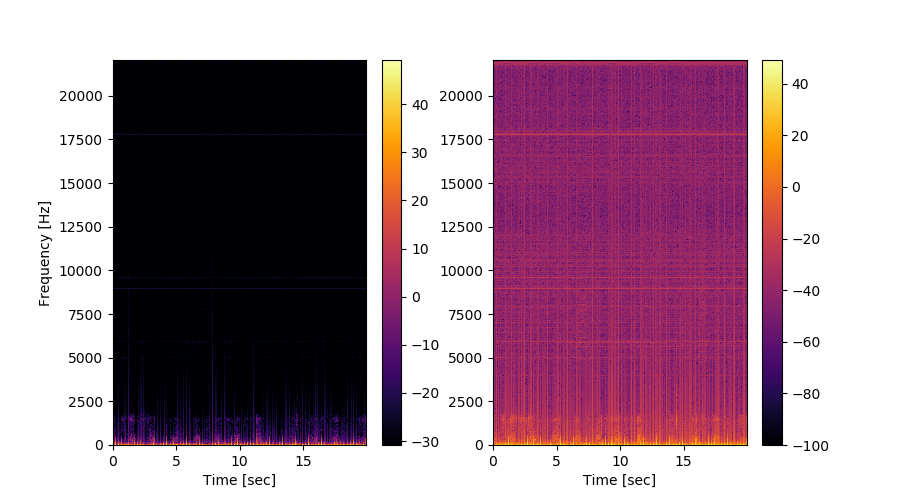

In [222]:
# Opciones del script
N = 2048     # Cantidad de muestras por cada frame
overlap = 0.5

# Obteniendo el espectrograma
t, f, S = get_spectrogram(audio, samplerate, N=N, padding=0, 
                          overlap=overlap, window='hamming', whole=False)

# Guardar valores de la dimensión del espectrograma
row_dim, col_dim = S.shape

# Definiendo la magnitud
X = np.abs(S)
print(X.shape)

# Y la fase de la señal (para reconstrucción)
phase = np.angle(S)
print(phase.shape)

# Graficando
%matplotlib notebook
plt.figure(figsize=(9,5))
plt.subplot(1,2,1)
plt.pcolormesh(t, f, librosa.amplitude_to_db(X), cmap='inferno')
plt.colorbar()
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

plt.subplot(1,2,2)
X_aux = np.maximum(X, 1e-05)
plt.pcolormesh(t, f, 20*np.log10(X_aux), cmap='inferno')
plt.colorbar()
plt.xlabel('Time [sec]')
plt.show()

# Probando con implementación NMF propia

Problema a definir:

$$X \approx WH$$
$$ s.a$$ $$ W,H \geq 0$$

Donde $X \in M^{N \times M}$, $W \in M^{N \times K}$ y $H \in M^{K \times M}$, donde el parámetro $K$ es la cantidad de variables a descomponer. Actúa como una variable oculta. Planteandolo como problema de optimización:

$$\min_{W,H} X - WH$$
$$ s.a$$ $$ W,H \geq 0$$

En nuestro caso, el parámetro $K = 2$ por tener una señal respiratoria y una señal cardíaca.

In [224]:
# Definición de la dimensión de la matriz a descomponer X
X_to_proc = X[:500,:]
N, M = X_to_proc.shape

# Definición de la variable oculta
K = 2

# Initialize Y randomly.
H_init = np.random.rand(K, M)
# Punto de partida
H = H_init

# Para realizar el algoritmo es necesario hacer optimización alternando
# las variables. En una iteración W será variable y H constante, mientras
# que en la siguiente será viceversa
max_iters = 30
residuals = []

print(X.shape)
print(N)
print(M)

input("\nPresione enter para continuar...\n")

for i in range(max_iters):
    # Para el caso de las iteraciones pares, H será constante y W será
    # una variable a optimizar.
    if i % 2 == 0:
        W = cp.Variable(shape=(N, K))
        constraint = [W >= 0]
    
    # Para el caso de las iteraciones impares, W será constante y H será
    # una variable a optimizar.
    else:
        H = cp.Variable(shape=(K, M))
        constraint = [H >= 0]

    # Se plantea la función objetivo
    obj = cp.Minimize(cp.norm(X_to_proc - W*H, 'fro'))
    
    # Definición del problema de optimización
    prob = cp.Problem(obj, constraint)
    
    # Resolución
    prob.solve(solver=cp.SCS, max_iters=10000)

    if prob.status != cp.OPTIMAL:
        print("Solver did not converge!")

    print('Iteration {}, residual norm {}'.format(i+1, prob.value))
    residuals.append(prob.value)

    # Convertir variable a un arreglo constante para la próxma iteración
    if i % 2 == 0:
        W = W.value
    else:
        H = H.value

(1025, 860)
500
860

Presione enter para continuar...

WARN: aa_init returned NULL, no acceleration applied.
Iteration 1, residual norm 2387.594188421811
WARN: aa_init returned NULL, no acceleration applied.
Solver did not converge!
Iteration 2, residual norm 1420.4868790187707
WARN: aa_init returned NULL, no acceleration applied.
Iteration 3, residual norm 1109.3502391235882
WARN: aa_init returned NULL, no acceleration applied.
Solver did not converge!
Iteration 4, residual norm 984.5403041383508
WARN: aa_init returned NULL, no acceleration applied.
Iteration 5, residual norm 917.0504125904367
WARN: aa_init returned NULL, no acceleration applied.
Solver did not converge!
Iteration 6, residual norm 887.6869304395829
WARN: aa_init returned NULL, no acceleration applied.
Iteration 7, residual norm 869.7674549012607
WARN: aa_init returned NULL, no acceleration applied.
Solver did not converge!
Iteration 8, residual norm 860.1603235275204
WARN: aa_init returned NULL, no acceleration applie

## Comparación con resultado de sklearn 

In [226]:
# Definiendo la magnitud
X = np.abs(S)

# Definiendo el modelo de NMF
model = NMF(n_components=2)

# Ajustando
W_sklearn = model.fit_transform(X_to_proc)
H_sklearn = model.components_

<IPython.core.display.Javascript object>


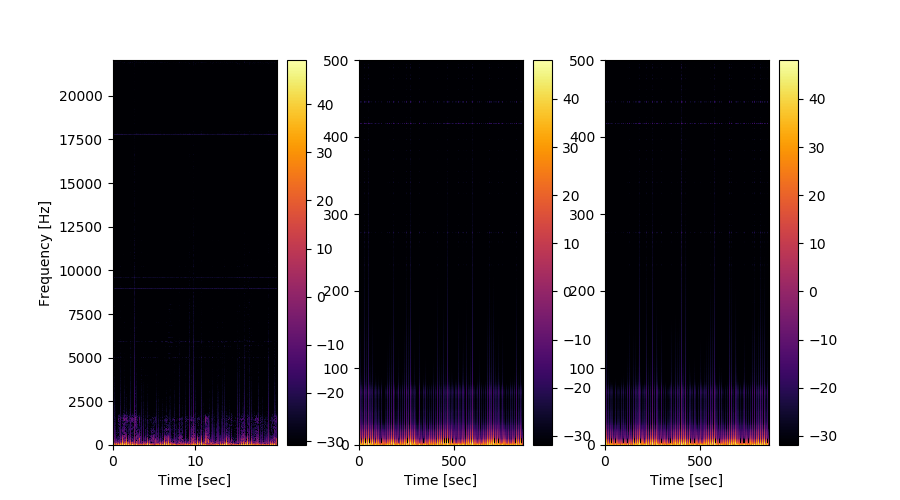

Error GUROBI: 52283.02759271869
Error SKLEARN: 52215.69583813719


In [227]:
# Graficando el resultado
%matplotlib notebook
plt.figure(figsize=(9,5))
plt.subplot(1,3,1)
plt.pcolormesh(t, f, librosa.amplitude_to_db(X), cmap='inferno')
plt.colorbar()
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

plt.subplot(1,3,2)
plt.pcolormesh(librosa.amplitude_to_db(np.matmul(W, H)), cmap='inferno')
plt.colorbar()
plt.xlabel('Time [sec]')

plt.subplot(1,3,3)
plt.pcolormesh(librosa.amplitude_to_db(np.matmul(W_sklearn, H_sklearn)), cmap='inferno')
plt.colorbar()
plt.xlabel('Time [sec]')
plt.show()

print(f"Error GUROBI: {sum(sum(abs(X_to_proc - np.matmul(W, H))))}")
print(f"Error SKLEARN: {sum(sum(abs(X_to_proc - np.matmul(W_sklearn, H_sklearn))))}")

# Con información extra

Ahora, debido que se conoce una de las filas de la matriz $H$, el problema se debiera plantear como:

$$\min_{W,H} X - W_1H_1 - W_2H$$
$$ s.a$$ $$ W_1, W_2, H_1 \geq 0$$

Donde $H \in M^{1 \times M}$ es la fila de información que se conoce.

<IPython.core.display.Javascript object>


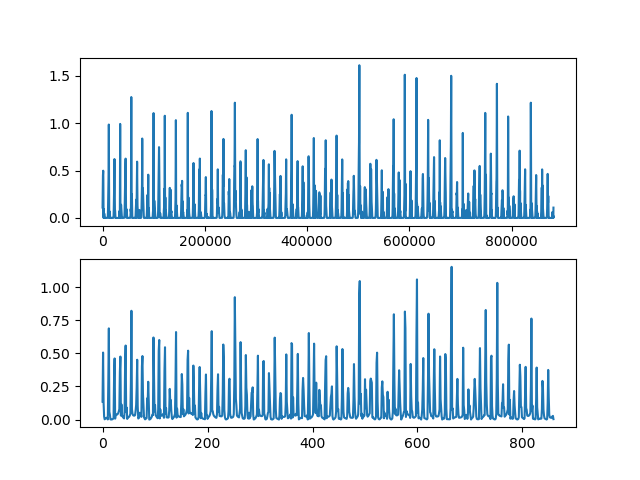

In [228]:
# Obteniendo la suma de wavelets
wavelets = get_upsampled_thresholded_wavelets(audio, samplerate, freq_pass=950, freq_stop=1000, 
                                               method='lowpass', lp_method='fir', 
                                               fir_method='kaiser', gpass=1, gstop=80, 
                                               plot_filter=False, levels_to_get=to_sust, 
                                               levels_to_decompose=6, wavelet='db4', mode='periodization', 
                                               threshold_criteria='hard', threshold_delta='universal',
                                               min_percentage=None, print_delta=False,
                                               plot_wavelets_1=False, plot_wavelets_2=False, normalize=True)
wavelet_final = abs(sum(wavelets))

%matplotlib notebook
plt.subplot(2,1,1)
plt.plot(wavelet_final)

plt.subplot(2,1,2)
H_new = np.array([abs(signal.resample(wavelet_final, num=M))])
plt.plot(H_new[0])

plt.show()

In [230]:
# Definición de la dimensión de la matriz a descomponer X
X_to_proc = X[:500,:]
N, M = X_to_proc.shape

# Definición de la variable oculta
K = 1

# Initialize H randomly.
H_init = np.random.rand(K, M)
# Punto de partida
H_1 = H_init

# Initialize W randomly.
W_init = np.random.rand(N, K)
W_2 = W_init

# Para realizar el algoritmo es necesario hacer optimización alternando
# las variables. En una iteración W será variable y H constante, mientras
# que en la siguiente será viceversa
max_iters = 30
residuals = []

print(X.shape)
print(N)
print(M)
print(H_new.shape)

input("\nPresione enter para continuar...\n")

for i in range(max_iters):
    # Para el caso de las iteraciones pares, H será constante y W será
    # una variable a optimizar.
    if i % 3 == 0:
        W_1 = cp.Variable(shape=(N, K))
        constraint = [W_1 >= 0]
    
    # Para el caso de las iteraciones impares, W será constante y H será
    # una variable a optimizar.
    elif i % 3 == 1:
        H_1 = cp.Variable(shape=(K, M))
        constraint = [H_1 >= 0]
        
    else:
        W_2 = cp.Variable(shape=(N, K))
        constraint = [W_2 >= 0]

    # Se plantea la función objetivo
    obj = cp.Minimize(cp.norm(X_to_proc - W_1*H_1 - W_2*H_new, 'fro'))
    
    # Definición del problema de optimización
    prob = cp.Problem(obj, constraint)
    
    # Resolución
    prob.solve(solver=cp.SCS, max_iters=10000)

    if prob.status != cp.OPTIMAL:
        print("Solver did not converge!")

    print('Iteration {}, residual norm {}'.format(i+1, prob.value))
    residuals.append(prob.value)

    # Convertir variable a un arreglo constante para la próxma iteración
    if i % 3 == 0:
        W_1 = W_1.value
    elif i % 3 == 1:
        H_1 = H_1.value
    else:
        W_2 = W_2.value

(1025, 860)
500
860
(1, 860)

Presione enter para continuar...

WARN: aa_init returned NULL, no acceleration applied.
Iteration 1, residual norm 2578.035049698911
WARN: aa_init returned NULL, no acceleration applied.
Iteration 2, residual norm 1513.2752279417984
WARN: aa_init returned NULL, no acceleration applied.
Iteration 3, residual norm 1361.4237635036077
WARN: aa_init returned NULL, no acceleration applied.
Iteration 4, residual norm 1337.6455733682799
WARN: aa_init returned NULL, no acceleration applied.
Solver did not converge!
Iteration 5, residual norm 1319.848503644578
WARN: aa_init returned NULL, no acceleration applied.
Iteration 6, residual norm 1301.2305413701474
WARN: aa_init returned NULL, no acceleration applied.
Iteration 7, residual norm 1289.4061135745978
WARN: aa_init returned NULL, no acceleration applied.
Solver did not converge!
Iteration 8, residual norm 1284.145316367912
WARN: aa_init returned NULL, no acceleration applied.
Iteration 9, residual norm 1276.104

In [ ]:
# Graficando el resultado
%matplotlib notebook
plt.figure(figsize=(9,5))
plt.subplot(1,3,1)
plt.pcolormesh(librosa.amplitude_to_db(X_to_proc), cmap='inferno')
plt.colorbar()
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

plt.subplot(1,3,2)
plt.pcolormesh(librosa.amplitude_to_db(np.matmul(W_1, H_1) + np.matmul(W_2, H_new)), cmap='inferno')
plt.colorbar()
plt.xlabel('Time [sec]')

plt.subplot(1,3,3)
plt.pcolormesh(librosa.amplitude_to_db(np.matmul(W_sklearn, H_sklearn)), cmap='inferno')
plt.colorbar()
plt.xlabel('Time [sec]')
plt.show()

print(f"Error NORMAL: {sum(sum(abs(X_to_proc - np.matmul(W, H))))}")
print(f"Error METODO: {sum(sum(abs(X_to_proc - np.matmul(W_1, H_1) - np.matmul(W_2, H_new))))}")
print(f"Error SKLEARN: {sum(sum(abs(X_to_proc - np.matmul(W_sklearn, H_sklearn))))}")

<IPython.core.display.Javascript object>


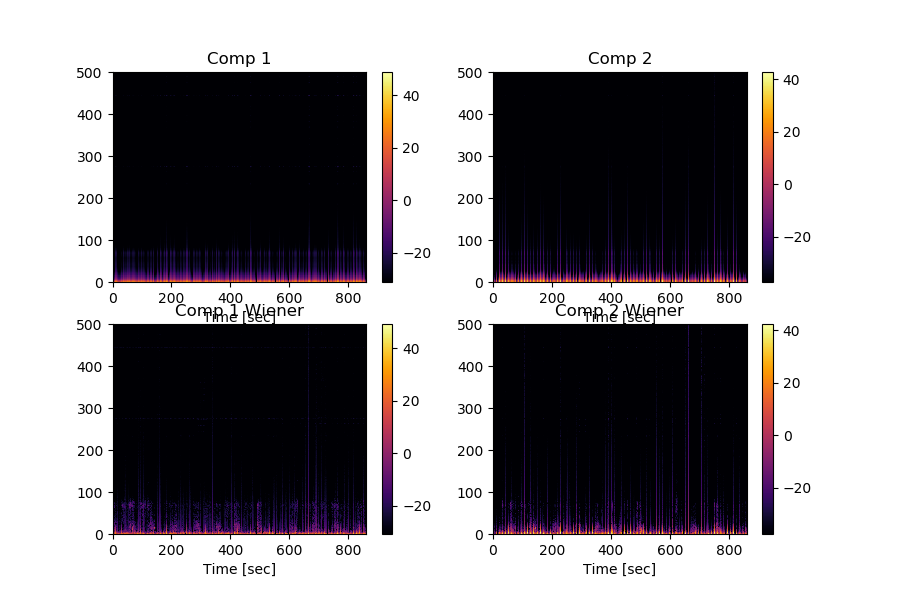

In [232]:
%matplotlib notebook
plt.figure(figsize=(9,6))
plt.subplot(2,2,1)
plt.pcolormesh(librosa.amplitude_to_db(np.matmul(W_1, H_1)), cmap='inferno')
plt.colorbar()
plt.title('Comp 1')
plt.xlabel('Time [sec]')

plt.subplot(2,2,2)
plt.pcolormesh(librosa.amplitude_to_db(np.matmul(W_2, H_new)), cmap='inferno')
plt.colorbar()
plt.title('Comp 2')
plt.xlabel('Time [sec]')

# Aplicando filtro de Wiener
W_total = np.concatenate((W_1, W_2), axis=1)
H_total = np.concatenate((H_1, H_new), axis=0)

comp_1 = wiener_filter(X_to_proc, np.matmul(W_1, H_1), W=W_total, H=H_total)
comp_2 = wiener_filter(X_to_proc, np.matmul(W_2, H_new), W=W_total, H=H_total)

plt.subplot(2,2,3)
plt.pcolormesh(librosa.amplitude_to_db(comp_1), cmap='inferno')
plt.colorbar()
plt.title('Comp 1 Wiener')
plt.xlabel('Time [sec]')

plt.subplot(2,2,4)
plt.pcolormesh(librosa.amplitude_to_db(comp_2), cmap='inferno')
plt.colorbar()
plt.title('Comp 2 Wiener')
plt.xlabel('Time [sec]')

plt.show()

(1025, 860)
(1025, 860)


<IPython.core.display.Javascript object>


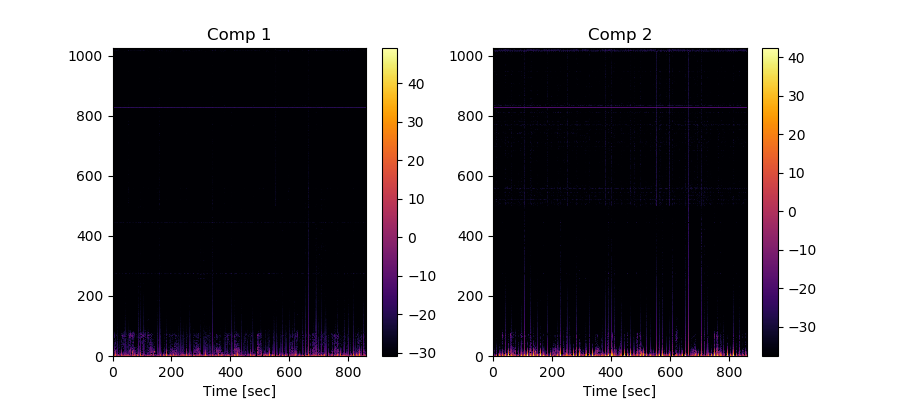

In [233]:
mat_to_fill = X[500:, :]
abs_recomp_1 = np.concatenate((comp_1, mat_to_fill), axis=0)
abs_recomp_2 = np.concatenate((comp_2, mat_to_fill), axis=0)
print(abs_recomp_1.shape)
print(abs_recomp_2.shape)

%matplotlib notebook
plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
plt.pcolormesh(librosa.amplitude_to_db(abs_recomp_1), cmap='inferno')
plt.colorbar()
plt.title('Comp 1')
plt.xlabel('Time [sec]')

plt.subplot(1,2,2)
plt.pcolormesh(librosa.amplitude_to_db(abs_recomp_2), cmap='inferno')
plt.colorbar()
plt.title('Comp 2')
plt.xlabel('Time [sec]')
plt.show()

In [234]:
# Recomponiendo
audio_comp_1 = get_inverse_spectrogram(abs_recomp_1 * np.exp(1j * phase), overlap=overlap, window='hamming', whole=False)
audio_comp_2 = get_inverse_spectrogram(abs_recomp_2 * np.exp(1j * phase), overlap=overlap, window='hamming', whole=False)

In [244]:
Audio(audio_comp_1, rate=samplerate)

In [241]:
audio_comp_1_64 = np.real(audio_comp_1.astype('float64'))
audio_comp_2_64 = np.real(audio_comp_2.astype('float64'))

audio_comp_2_64.dtype

c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  """Entry point for launching an IPython kernel.
c:\users\chris\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  


dtype('float64')

In [243]:
sf.write(f'{filename}_comp_1.wav', audio_comp_1_64, samplerate)
sf.write(f'{filename}_comp_2.wav', audio_comp_2_64, samplerate)

In [256]:
sf.write(f'{filename}_sum_wavelet_{to_sust}.wav', sum(wavelets), samplerate)

# NMF con características temporales

Se asume que el sonido cardíaco es el sonido rescatado de los wavelets, y se plantea el problema de la forma 

$$\min_{W,H} X - \alpha_1 H_1 - \alpha_2 H$$
$$ s.a$$ $$ \alpha_1, \alpha_2 \geq 0$$

Donde $X, H, H_1 \in M^{1 \times M}$ y $\alpha_1, \alpha_2 \in R$ es la fila de información que se conoce.

In [54]:
# Obteniendo la suma de wavelets
to_sust = [4]
wavelets = get_upsampled_thresholded_wavelets(audio, samplerate, freq_pass=950, freq_stop=1000, 
                                               method='lowpass', lp_method='fir', 
                                               fir_method='kaiser', gpass=1, gstop=80, 
                                               plot_filter=False, levels_to_get=to_sust, 
                                               levels_to_decompose=6, wavelet='db4', mode='periodization', 
                                               threshold_criteria='hard', threshold_delta='universal',
                                               min_percentage=None, print_delta=False,
                                               plot_wavelets_1=False, plot_wavelets_2=False, normalize=True)
wavelet_final = sum(wavelets)

# Aplicando downsamplig
new_rate, dwns_audio = downsampling_signal(audio, samplerate, 950, 1000, 
                                method='lowpass', lp_method='fir', 
                                fir_method='kaiser', gpass=1, gstop=80,
                                correct_by_gd=True, gd_padding='periodic',
                                plot_filter=False, normalize=True)

new_rate, dwns_wavel = downsampling_signal(wavelet_final, samplerate, 950, 1000, 
                                method='lowpass', lp_method='fir', 
                                fir_method='kaiser', gpass=1, gstop=80,
                                correct_by_gd=True, gd_padding='periodic',
                                plot_filter=False, normalize=True)
print(new_rate)
print(dwns_audio.shape)
print(dwns_wavel.shape)

2004
(40091,)
(40091,)


In [55]:
# Definición de la variable oculta
K = 1

# Initialize H randomly.
H_init = np.random.rand(K, len(dwns_audio))
# Punto de partida
H_1 = H_init

# Para realizar el algoritmo es necesario hacer optimización alternando
# las variables. En una iteración W será variable y H constante, mientras
# que en la siguiente será viceversa
max_iters = 30
residuals = []

audio_to_put = np.array([dwns_audio])
wavel_to_put = np.array([dwns_wavel])

print(audio_to_put.shape)
print(wavel_to_put.shape)

input("\nPresione enter para continuar...\n")

for i in range(max_iters):
    # Para el caso de las iteraciones pares, H será constante y W será
    # una variable a optimizar.
    if i % 2 == 1:
        H_1 = cp.Variable(shape=(K, len(dwns_audio)))
        a_2 = cp.Variable()
        constraint = [a_2 >= 0]
    
    # Para el caso de las iteraciones impares, W será constante y H será
    # una variable a optimizar.        
    else:
        a_1 = cp.Variable()
        a_2 = cp.Variable()
        constraint = [a_1 >= 0, a_2 >= 0]

    # Se plantea la función objetivo
    obj = cp.Minimize(cp.norm(audio_to_put - a_1*H_1 - a_2*wavel_to_put, 'fro'))
    
    # Definición del problema de optimización
    prob = cp.Problem(obj, constraint)
    
    # Resolución
    prob.solve(solver=cp.SCS, max_iters=10000)

    if prob.status != cp.OPTIMAL:
        print("Solver did not converge!")

    print('Iteration {}, residual norm {}'.format(i+1, prob.value))
    residuals.append(prob.value)

    # Convertir variable a un arreglo constante para la próxma iteración
    if i % 2 == 1:
        H_1 = H_1.value
    else:
        a_1 = a_1.value
        
a_2 = a_2.value

(1, 40091)
(1, 40091)

Presione enter para continuar...

WARN: aa_init returned NULL, no acceleration applied.
Iteration 1, residual norm 21.873763126237087
WARN: aa_init returned NULL, no acceleration applied.
Iteration 2, residual norm -3.8231230832140085e-05
WARN: aa_init returned NULL, no acceleration applied.
Iteration 3, residual norm 8.526351040633403e-12
WARN: aa_init returned NULL, no acceleration applied.
Iteration 4, residual norm -3.823123399123709e-05
WARN: aa_init returned NULL, no acceleration applied.
Iteration 5, residual norm 8.834532432935139e-12
WARN: aa_init returned NULL, no acceleration applied.
Iteration 6, residual norm -3.823123401334116e-05
WARN: aa_init returned NULL, no acceleration applied.
Iteration 7, residual norm 9.348168069400937e-12
WARN: aa_init returned NULL, no acceleration applied.
Iteration 8, residual norm -3.823123089844385e-05
WARN: aa_init returned NULL, no acceleration applied.
Iteration 9, residual norm 1.0786347808361065e-11
WARN: aa_init

In [56]:
print(a_1)
print(a_2)
print(H_1)

0.0006214644858864373
0.01862375907298756
[[  73.64459574 -104.48810783  -63.08685125 ...  173.83185333
   173.84806907  238.82261443]]


<IPython.core.display.Javascript object>


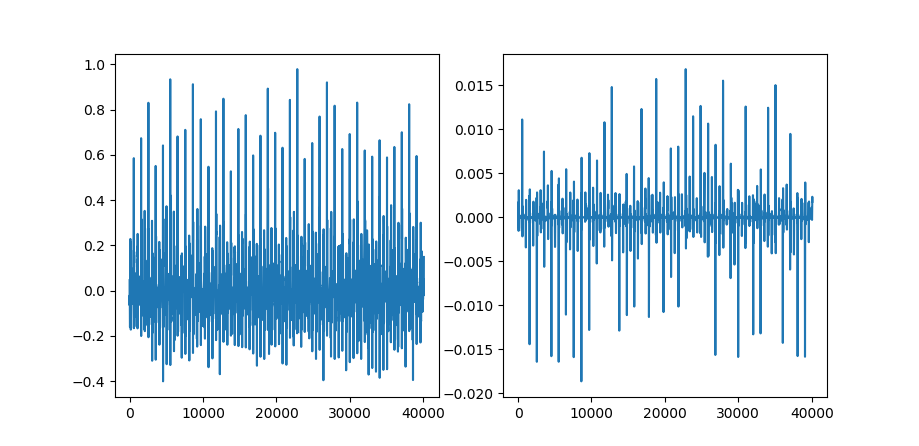

In [57]:
%matplotlib notebook
plt.subplot(1,2,1)
plt.plot(a_1 * H_1[0])

plt.subplot(1,2,2)
plt.plot(a_2 * dwns_wavel)

plt.show()

In [32]:
upsampled_comp_1 = upsampling_signal(a_1 * H_1[0], new_rate, samplerate,
                                  N_desired=None, method='lowpass',
                                  trans_width=50, lp_method='fir', 
                                  fir_method='kaiser', gpass=1, gstop=80, 
                                  correct_by_gd=True, gd_padding='periodic',
                                  plot_filter=False, plot_signals=False,
                                  normalize=True)


Audio(upsampled_comp_1, rate=samplerate)

# NMF con características temporales fijando $a_2$

Se asume que el sonido cardíaco es el sonido rescatado de los wavelets, y se plantea el problema de la forma 

$$\min_{W,H} X - \alpha_1 H_1 - \alpha_2 H$$
$$ s.a$$ $$ \alpha_1 \geq 0$$

Donde $X, H, H_1 \in M^{1 \times M}$ y $\alpha_1, \alpha_2 \in R$ es la fila de información que se conoce.

In [ ]:
# Definición de a_2
a_2_fix = 0.5

# Definición de la variable oculta
K = 1

# Initialize H randomly.
H_init = np.random.rand(K, len(dwns_audio))
# Punto de partida
H_1 = H_init

# Para realizar el algoritmo es necesario hacer optimización alternando
# las variables. En una iteración W será variable y H constante, mientras
# que en la siguiente será viceversa
max_iters = 30
residuals = []

audio_to_put = np.array([dwns_audio])
wavel_to_put = np.array([dwns_wavel])

print(audio_to_put.shape)
print(wavel_to_put.shape)

input("\nPresione enter para continuar...\n")

for i in range(max_iters):
    # Para el caso de las iteraciones pares, H será constante y W será
    # una variable a optimizar.
    if i % 2 == 1:
        H_1 = cp.Variable(shape=(K, len(dwns_audio)))
        constraint = []
        
    # Para el caso de las iteraciones impares, W será constante y H será
    # una variable a optimizar.        
    else:
        a_1 = cp.Variable()
        constraint = [a_1 >= 0]

    # Se plantea la función objetivo
    obj = cp.Minimize(cp.norm(audio_to_put - a_1*H_1 - a_2_fix*wavel_to_put, 'fro'))
    
    # Definición del problema de optimización
    prob = cp.Problem(obj, constraint)
    
    # Resolución
    prob.solve(solver=cp.SCS, max_iters=10000)

    if prob.status != cp.OPTIMAL:
        print("Solver did not converge!")

    print('Iteration {}, residual norm {}'.format(i+1, prob.value))
    residuals.append(prob.value)

    # Convertir variable a un arreglo constante para la próxma iteración
    if i % 2 == 1:
        H_1 = H_1.value
    else:
        a_1 = a_1.value
        
a_2 = a_2.value